# alterações:
- Negative pressure -> consider as typos and multiply by -1 (turn positive)
- add feature BMI (IMC), desconsider weight and height in modelling (worst results overall)
- showing only LightGBM Grid CV model results

# A Empresa Cardio Catch Diseases ( CCD )

   A Cardio Catch Diseases é uma empresa especializada em detecção de doenças cardíacas em estágios iniciais. O
seu modelo de negócio é do tipo Serviço, ou seja, a empresa ofereço o diagnóstico precoce de uma doença
cardiovascular por um certo preço.

   Atualmente, o diagnóstico de uma doença cardiovascular é feita manualmente por uma equipe de especialistas.
A precisão atual do diagnóstico varia entre 55\% e 65\%, devido a complexidade do diagnóstico e também da
fadiga da equipe que se revezam em turnos para minimizar os riscos. O custo de cada diagnóstico, incluindo os
aparelhos e a folha de pagamento dos analistas, gira em torno de RS 1.000,00.

   O preço do diagnóstico, pago pelo cliente, varia de acordo com a precisão conseguida pelo time de
especialistas, o cliente paga RS 500,00 a cada 5\% de acurácia acima de 50\%\. Por exemplo, para uma precisão de
55\% , o diagnóstico custa RS 500,00 para o cliente, para uma precisão de 60\% , o valor é de RS 1000,00 e assim
por diante. Se a precisão do diagnóstico for 50\% o cliente não paga por ele.

   Observe que a variação da precisão dada pelo time de especialistas, faz com que a empresa tenha ora uma
operação com lucro, receita maior que o custo, ora uma operação com prejuízo, receita menor que o custo. Essa
instabilidade do diagnóstico faz com que a empresa tenha um Cashflow imprevisível.

   O seu objetivo como o Cientista de Dados contratado pela Cardio Catch Diseases é criar uma ferramenta que aumente a precisão do diagnóstico e que essa precisão seja estável para todos os diagnósticos. Portanto o seu trabalho como Data Scientist é criar um ferramenta de classificação de doentes, como uma precisão estável. Junto com a ferramenta, você precisa enviar um relatório para o CEO da Cardio Catch Diseases, reportando os resultados e respondendo às seguintes perguntas: ( Ele provavelmente irá fazer essas pergunta no dia da sua apresentação. )
1. Qual a Acurácia e a Precisão da ferramenta?
2. Quanto lucro a Cardio Catch Diseases passará a ter com a nova ferramenta?
3. Qual a Confiabilidade do resultado dados pela nova ferramenta?


## Entendimento sobre o problema

Criar um modelo de classificação com uma precisão que seja rentável para a operação, ou seja, acima de 60\% para cima.

Com essa nova performance, verificar o ganho da operação e identificar possíveis melhorias. 

O caso permite algumas suposições de hipóteses relacionadas às variáveis que deverão ser validadas durante a análise.

## <div style="color:white;display:fill;border-radius:5px;background-color:#264653;letter-spacing:0.5px;overflow:hidden"><p style="padding:20px;color:white;overflow:hidden;text-align: center;margin:0;font-size:120%">Data Dictionary</p></div>

Age | Objective Feature | age | int (days)

Height | Objective Feature | height | int (cm) |

Weight | Objective Feature | weight | float (kg) |

Gender | Objective Feature | gender | categorical code |

Systolic blood pressure | Examination Feature | ap_hi | int |

Diastolic blood pressure | Examination Feature | ap_lo | int |

Cholesterol | Examination Feature | cholesterol | 1: normal, 2: above normal, 3: well above normal |

Glucose | Examination Feature | gluc | 1: normal, 2: above normal, 3: well above normal |

Smoking | Subjective Feature | smoke | binary |

Alcohol intake | Subjective Feature | alco | binary |

Physical activity | Subjective Feature | active | binary |

Presence or absence of cardiovascular disease | Target Variable | cardio | binary |

*All of the dataset values were collected at the moment of medical examination*.

## <div style="color:white;display:fill;border-radius:5px;background-color:#264653;letter-spacing:0.5px;overflow:hidden"><p style="padding:20px;color:white;overflow:hidden;text-align: center;margin:0;font-size:120%">Imports</p></div>

In [103]:
import pandas as pd

import numpy as np

import seaborn as sns

import inflection

import matplotlib.pyplot as plt

from sklearn.preprocessing          import RobustScaler, MinMaxScaler

from IPython.core.display           import HTML

from sklearn.model_selection        import train_test_split, cross_val_score
from scipy                          import stats as ss

In [104]:
#!jt -t gruvboxd -T -N -kl

## <div style="color:white;display:fill;border-radius:5px;background-color:#264653;letter-spacing:0.5px;overflow:hidden"><p style="padding:20px;color:white;overflow:hidden;text-align: center;margin:0;font-size:120%">Helper Functions</p></div>

In [105]:
def column_clean(df):
    for i in range(len(df.columns)):
        df.columns.values[i] = df.columns[i].strip().replace(' ', '_').replace('/', '_')
    
    snakecase = lambda x: inflection.underscore( x )
    df.columns = list(map( snakecase, df.columns ))
    
    rename_dict = {
    'gluc': 'glucose_level',
    'alco': 'if_alcohol',
    'smoke': 'if_smoke',
    'active': 'if_active'
    }

    
    df.rename(columns=rename_dict, inplace=True)
    return df 
        
def pressure_adjustment(x):
    if x == 1 or x == 2:
        return x * 100
    elif 2 < x <= 24:
        return x * 10
    elif 24 < x <= 240:
        return x
    elif 241 <= x <= 2400:
        return x / 10
    elif x < 100:
        return x
    else:
        return x / 100
    
def preprocessamento(df):
    # Converting age : days to years
    df['age'] = (df['age']/365).astype(np.int64)
    
    # Creating feature IMC (BMI) and encoding it (target_encoding) :
    df['imc'] = df['weight'] / ((df['height']/100)**2)
    df['faixa_imc'] = df['imc'].apply(lambda x: 'muito_abaixo_peso' if x < 17 
                                                                    else  'abaixo_peso' if 17 <= x < 18.5 
                                                                    else  'normal' if 18.5 <= x < 25 
                                                                    else  'acima_peso' if 25 <= x < 30
                                                                    else  'obesidade_1' if 30 <= x < 35
                                                                    else  'obesidade_2' if 35 <= x < 40
                                                                    else  'obesidade_3')
    
    mean_encoding = df.groupby('faixa_imc')['cardio'].mean().reset_index()

    mean_encoding_dict = mean_encoding.set_index('faixa_imc')['cardio'].to_dict()

    df['faixa_imc_encoded'] = df['faixa_imc'].map(mean_encoding_dict)

    # Formating pressure data

    df['ap_hi'] = df['ap_hi'].apply( lambda x : pressure_adjustment(x))
    df['ap_lo'] = df['ap_lo'].apply( lambda x : pressure_adjustment(x))

    # pressure rescale

    df['ap_hi_rescaled'] = RobustScaler().fit_transform(df[['ap_hi']])
    df['ap_lo_rescaled'] = RobustScaler().fit_transform(df[['ap_lo']])

    return df

def summary_stats(df):
    # central tendency: mean, median   
    numerical_features = df.select_dtypes(include = ['number']).columns.values
    df = df[numerical_features]
        
    
    mean_ = pd.DataFrame(df.apply(np.mean))
    std_ = pd.DataFrame(df.apply(np.std))
    median_ = pd.DataFrame(df.apply(np.median))
    
    min_ = pd.DataFrame(df.apply(min))
    max_ = pd.DataFrame(df.apply(max))
    range_ = pd.DataFrame(df.apply(lambda x: x.max() - x.min()))
    q1_ = pd.DataFrame(df.apply(lambda x: np.percentile(x,25)))
    q3_ = pd.DataFrame(df.apply(lambda x: np.percentile(x,75)))
    
    skewness_= pd.DataFrame(df.apply(lambda x: x.skew()))
    kurtosis_ = pd.DataFrame(df.apply(lambda x: x.kurtosis()))
    
    summary = pd.concat([mean_, std_, median_, min_, max_, range_, q1_,q3_, skewness_, kurtosis_],axis=1)
    summary.columns = ['mean','std','median','min','max', 'range', '25%','75%', 'skew', 'kurt']
 

    #cm = sns.light_palette("#e76f51", as_cmap = True)
    
    display(summary.style.format('{:.2f}'))
            #.background_gradient(subset=(summary.index[2:],summary.columns[:])))#,cmap=cm))
        
def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max( 0 , chi2 - (k-1)*(r-1)/(n-1))
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt( (chi2corr/n) / (min(kcorr-1, rcorr-1)))

def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [18,6]
    plt.rcParams['font.size'] = 18
    
    display( HTML('<style>.container{width:100% !important; }</style'))
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False)
    
    sns.set()

In [106]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


C:\Users\Pichau\anaconda3\lib\site-packages\IPython\core\magics\pylab.py:159: UserWarning: pylab import has clobbered these variables: ['cm', 'matrix']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


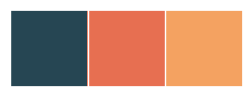

In [107]:
# Configurações de Layout, Matlab e Seaborn
LAYOUT_PALETTE = ["#264653", "#e76f51", "#f4a261"]#, "#2a9d8f", "#dda15e", "#63897a"]
LAYOUT_PALETTE2 = ["#264653", "#e76f51", "#f4a261", "#2a9d8f", "#dda15e", "#63897a"]
LAYOUT_PALETTE3 = ["#264653", "#e76f51", "#f4a261", "#2a9d8f", "#dda15e", "#63897a", "#282828" ]
sns.set_palette(sns.color_palette(LAYOUT_PALETTE))

cm = sns.light_palette("#e76f51")

sns.palplot(sns.color_palette(LAYOUT_PALETTE))

## <div style="color:white;display:fill;border-radius:5px;background-color:#264653;letter-spacing:0.5px;overflow:hidden"><p style="padding:20px;color:white;overflow:hidden;text-align: center;margin:0;font-size:120%">Data Loading</p></div>

In [6]:
data_raw = pd.read_csv('data/cardio_train.csv', delimiter=';')

In [7]:
data_raw['gender'].value_counts()

1    45530
2    24470
Name: gender, dtype: int64

## <div style="color:white;display:fill;border-radius:5px;background-color:#264653;letter-spacing:0.5px;overflow:hidden"><p style="padding:20px;color:white;overflow:hidden;text-align: center;margin:0;font-size:120%">Data Description</p></div>

In [8]:
print('Número de linhas: {}'.format(data_raw.shape[0]))
print('Número de colunas: {}'.format(data_raw.shape[1]))

Número de linhas: 70000
Número de colunas: 13


In [9]:
# checking data info
data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           70000 non-null  int64  
 1   age          70000 non-null  int64  
 2   gender       70000 non-null  int64  
 3   height       70000 non-null  int64  
 4   weight       70000 non-null  float64
 5   ap_hi        70000 non-null  int64  
 6   ap_lo        70000 non-null  int64  
 7   cholesterol  70000 non-null  int64  
 8   gluc         70000 non-null  int64  
 9   smoke        70000 non-null  int64  
 10  alco         70000 non-null  int64  
 11  active       70000 non-null  int64  
 12  cardio       70000 non-null  int64  
dtypes: float64(1), int64(12)
memory usage: 6.9 MB


## <div style="color:white;display:fill;border-radius:5px;background-color:#264653;letter-spacing:0.5px;overflow:hidden"><p style="padding:20px;color:white;overflow:hidden;text-align: center;margin:0;font-size:120%">Data Preprocessing</p></div>

In [10]:
# safe copy
df_preprocessing = data_raw.copy()

In [11]:
# cleaning columns ( spaces, lowercase, rename )
column_clean(df_preprocessing);

# preprocessing dataset (age convertion, feature IMC (bmi) created, target encoding IMC, pressure adjustment in 'ap_hi' and 'ap_lo')
preprocessamento(df_preprocessing);

## <div style="color:white;display:fill;border-radius:5px;background-color:#264653;letter-spacing:0.5px;overflow:hidden"><p style="padding:20px;color:white;overflow:hidden;text-align: center;margin:0;font-size:120%">Exploratory Data Analysis</p></div>

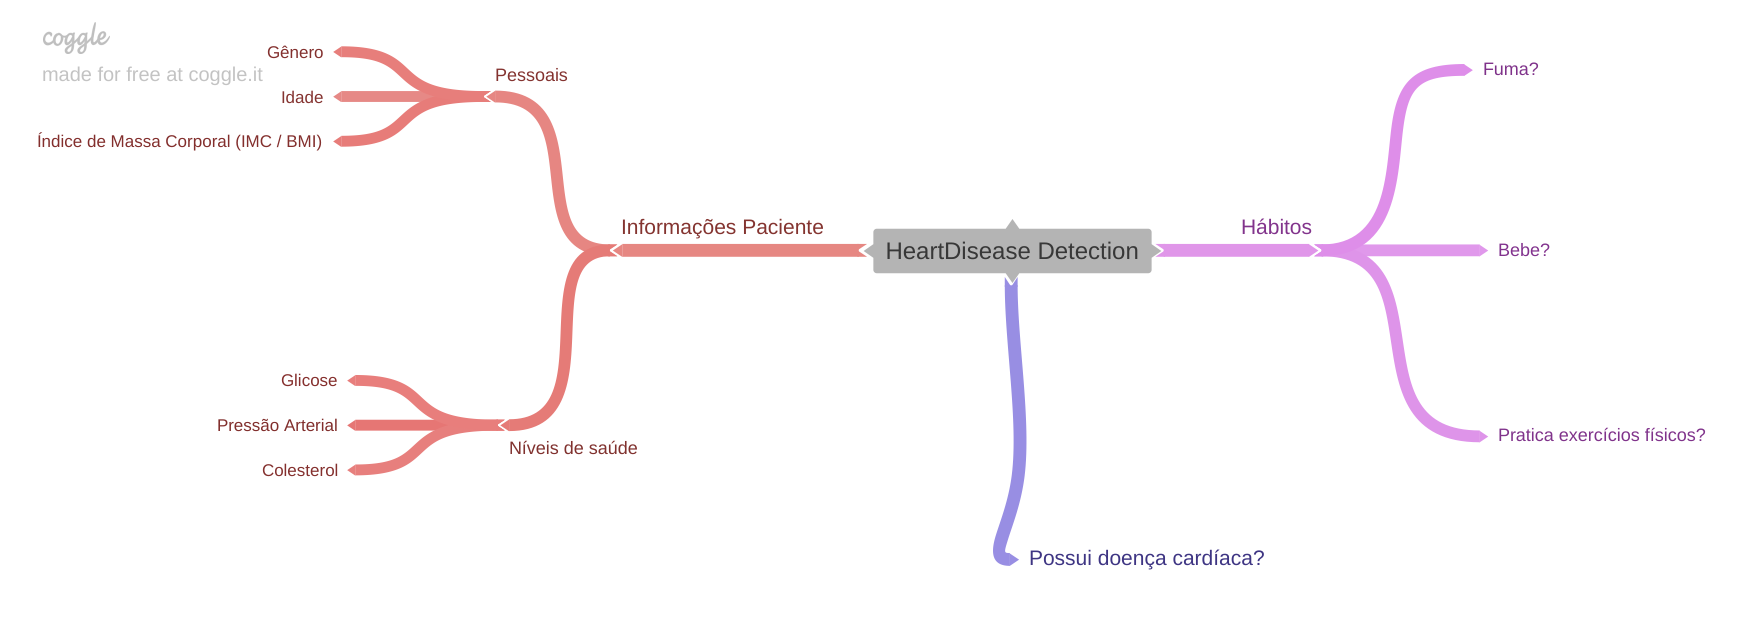

In [12]:
# safe copy
data_eda = df_preprocessing.copy()

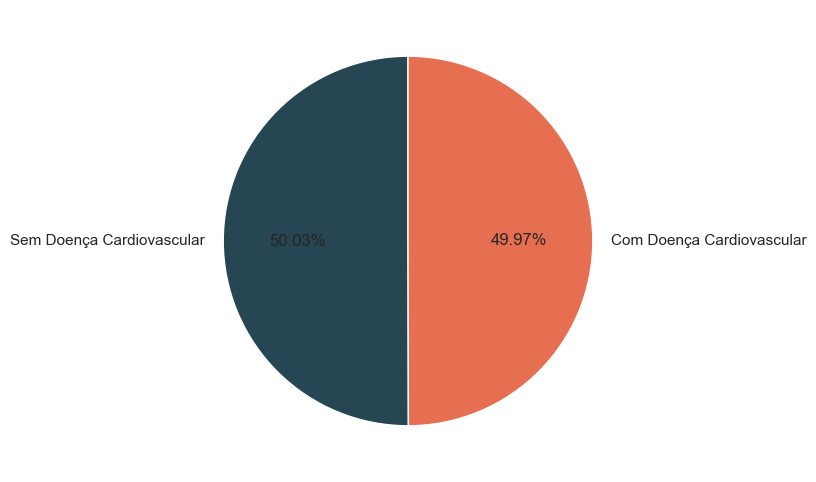

In [13]:
# checking target variable
value_counts = data_eda['cardio'].value_counts()

plt.figure(figsize=(6, 6))
plt.pie(value_counts, labels=['Sem Doença Cardiovascular', 'Com Doença Cardiovascular'], autopct='%1.2f%%', startangle=90);


In [14]:
# pre adjusments summary - without preprocessing
summary_stats(data_raw)

,mean,std,median,min,max,range,25%,75%,skew,kurt
id,49972.42,28851.10,50001.50,0.00,99999.00,99999.00,25006.75,74889.25,-0.00,-1.20
age,19468.87,2467.23,19703.00,10798.00,23713.00,12915.00,17664.00,21327.00,-0.31,-0.82
gender,1.35,0.48,1.00,1.00,2.00,1.00,1.00,2.00,0.63,-1.60
height,164.36,8.21,165.00,55.00,250.00,195.00,159.00,170.00,-0.64,7.94
weight,74.21,14.40,72.00,10.00,200.00,190.00,65.00,82.00,1.01,2.59
ap_hi,128.82,154.01,120.00,-150.00,16020.00,16170.00,120.00,140.00,85.30,7580.07
ap_lo,96.63,188.47,80.00,-70.00,11000.00,11070.00,80.00,90.00,32.11,1425.91
cholesterol,1.37,0.68,1.00,1.00,3.00,2.00,1.00,2.00,1.59,0.99
gluc,1.23,0.57,1.00,1.00,3.00,2.00,1.00,1.00,2.40,4.29
smoke,0.09,0.28,0.00,0.00,1.00,1.00,0.00,0.00,2.91,6.44


In [15]:
# summary with preprocessing
summary_stats(data_eda)

,mean,std,median,min,max,range,25%,75%,skew,kurt
id,49972.42,28851.10,50001.50,0.00,99999.00,99999.00,25006.75,74889.25,-0.00,-1.20
age,52.84,6.77,53.00,29.00,64.00,35.00,48.00,58.00,-0.31,-0.82
gender,1.35,0.48,1.00,1.00,2.00,1.00,1.00,2.00,0.63,-1.60
height,164.36,8.21,165.00,55.00,250.00,195.00,159.00,170.00,-0.64,7.94
weight,74.21,14.40,72.00,10.00,200.00,190.00,65.00,82.00,1.01,2.59
ap_hi,126.97,17.30,120.00,-150.00,240.00,390.00,120.00,140.00,0.59,5.96
ap_lo,81.66,10.25,80.00,-70.00,208.80,278.80,80.00,90.00,0.81,9.59
cholesterol,1.37,0.68,1.00,1.00,3.00,2.00,1.00,2.00,1.59,0.99
glucose_level,1.23,0.57,1.00,1.00,3.00,2.00,1.00,1.00,2.40,4.29
if_smoke,0.09,0.28,0.00,0.00,1.00,1.00,0.00,0.00,2.91,6.44


In [16]:
# Transforming categorical variables to EDA

data_eda['gender'] = data_eda['gender'].apply( lambda x: 'Female' if x == 1 else 'Male')
data_eda['cholesterol'] = data_eda['cholesterol'].map( lambda x: 'Normal' if x == 1 else 'Above Normal' if x == 2 else 'Well Above Normal')
data_eda['glucose_level'] = data_eda['glucose_level'].map(lambda x: 'Normal' if x == 1 else 'Above Normal' if x == 2 else 'Well Above Normal')
data_eda['if_smoke'] = data_eda['if_smoke'].apply( lambda x: 'No' if x == 0 else 'Yes')
data_eda['if_alcohol'] = data_eda['if_alcohol'].apply( lambda x: 'No' if x == 0 else 'Yes')
data_eda['if_active'] = data_eda['if_active'].apply( lambda x: 'No' if x == 0 else 'Yes')


In [17]:
data_eda.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,glucose_level,if_smoke,if_alcohol,if_active,cardio,imc,faixa_imc,faixa_imc_encoded,ap_hi_rescaled,ap_lo_rescaled
0,0,50,Male,168,62.0,110.0,80.0,Normal,Normal,No,No,Yes,0,21.967120,normal,0.401318,-0.5,0.0
1,1,55,Female,156,85.0,140.0,90.0,Well Above Normal,Normal,No,No,Yes,1,34.927679,obesidade_1,0.604160,1.0,1.0
2,2,51,Female,165,64.0,130.0,70.0,Well Above Normal,Normal,No,No,No,1,23.507805,normal,0.401318,0.5,-1.0
3,3,48,Male,169,82.0,150.0,100.0,Normal,Normal,No,No,Yes,1,28.710479,acima_peso,0.510085,1.5,2.0
4,4,47,Female,156,56.0,100.0,60.0,Normal,Normal,No,No,No,0,23.011177,normal,0.401318,-1.0,-2.0


In [18]:
num_attributes = data_eda.select_dtypes( include=['int64','float64'])
cat_attributes = data_eda.select_dtypes( exclude=['int64','float64'])

num_attributes_raw = data_raw.select_dtypes( include=['int64','float64'])
cat_attributes_raw = data_raw.select_dtypes( exclude=['int64','float64'])

### Numerical Attributes Analysis

#### Univariada

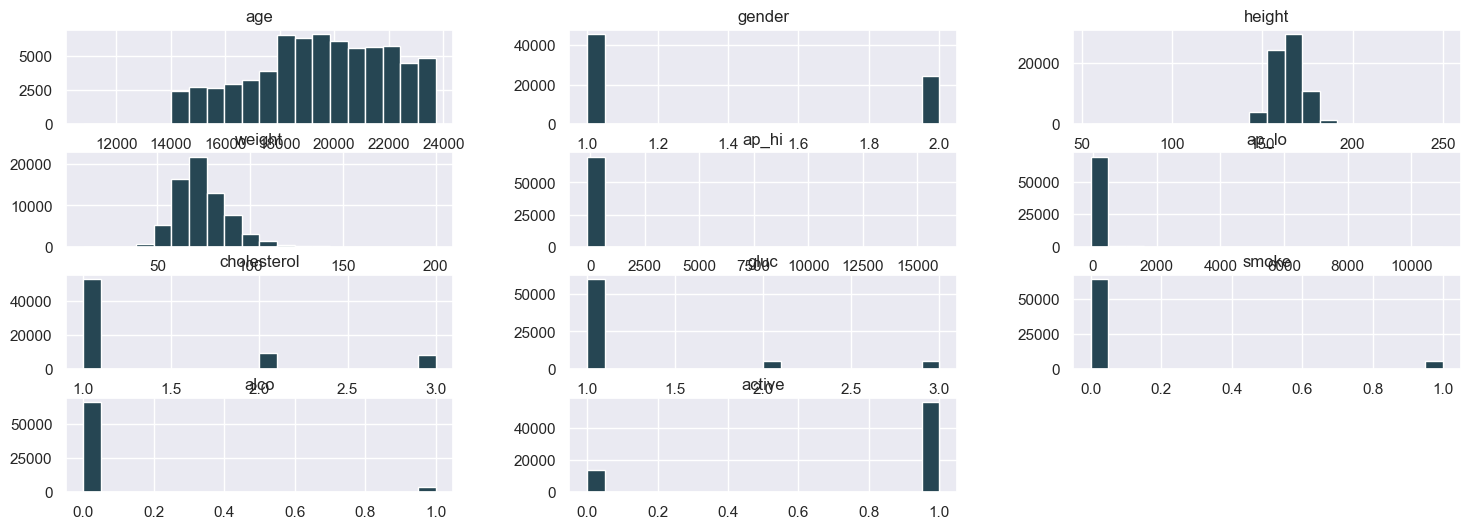

In [19]:
num_attributes_raw.drop(['id', 'cardio'],axis=1).hist( bins = 20, color= '#264653');

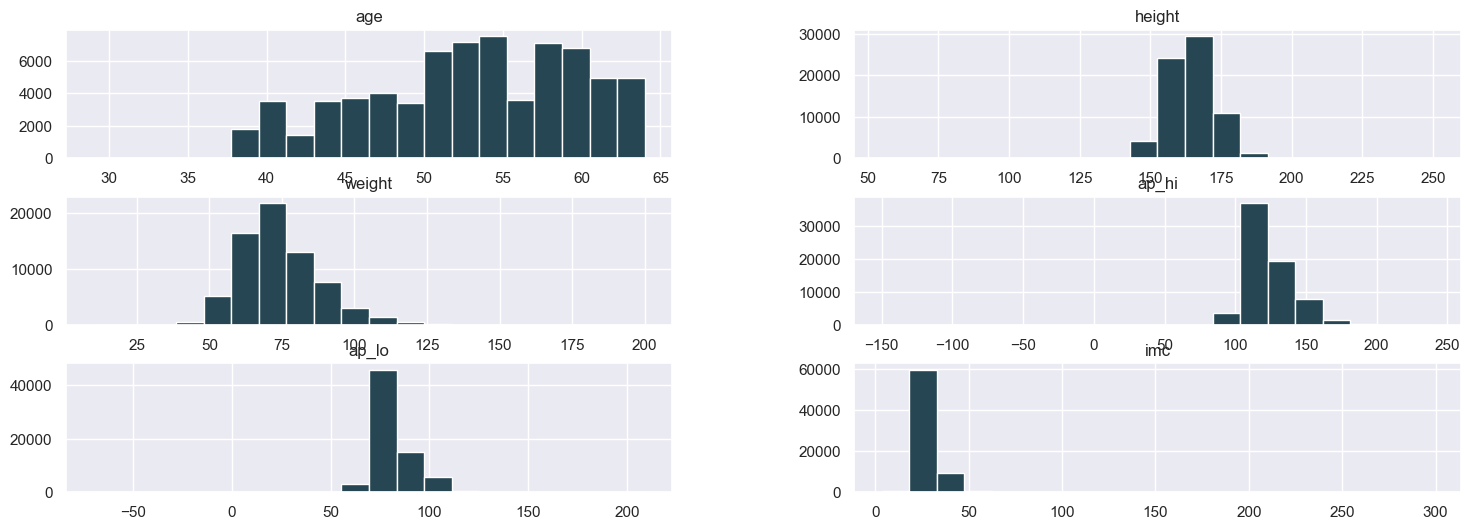

In [20]:
num_attributes.drop(['id', 'cardio', 'faixa_imc_encoded', 'ap_hi_rescaled', 'ap_lo_rescaled'],axis=1).hist( bins = 20, color= '#264653');

#### Bivariada

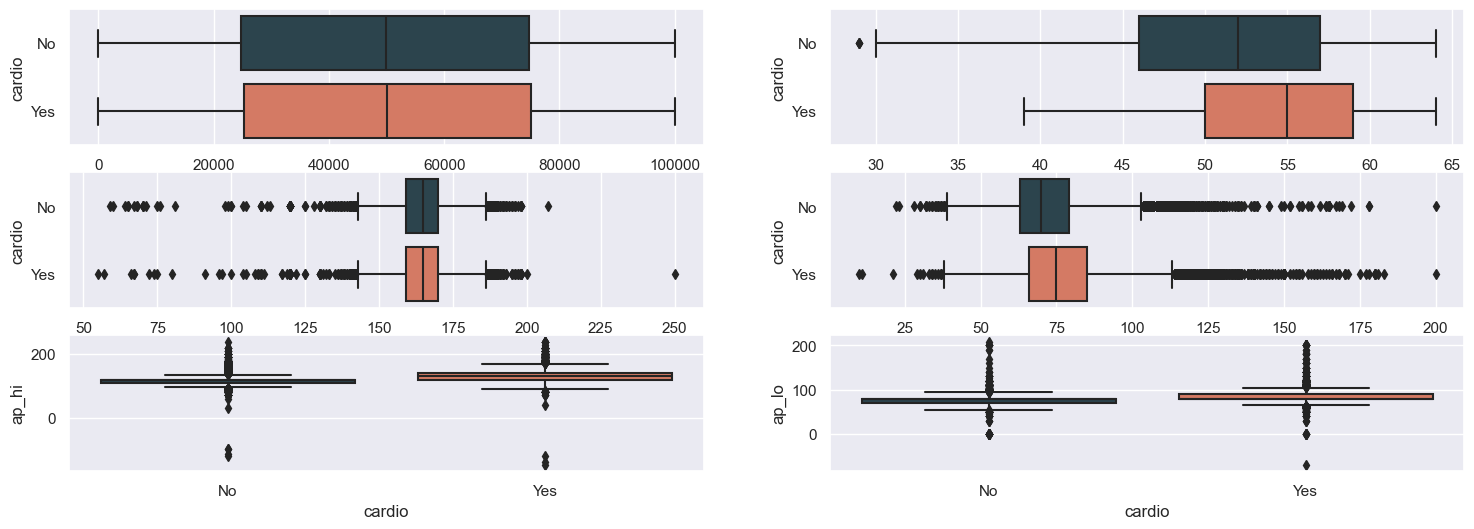

In [21]:
# Verifying numerical variables with target
data_aux = data_eda.copy()
data_aux['cardio'] = data_aux['cardio'].apply( lambda x: 'No' if x == 0 else 'Yes')

plt.subplot( 3, 2, 1)
sns.boxplot( y = 'cardio', x = 'id', data= data_aux, palette=LAYOUT_PALETTE)

plt.subplot( 3, 2, 2)
sns.boxplot( y = 'cardio', x = 'age', data= data_aux, palette=LAYOUT_PALETTE)

plt.subplot( 3, 2, 3)
sns.boxplot( y = 'cardio', x = 'height', data= data_aux, palette=LAYOUT_PALETTE)

plt.subplot( 3, 2, 4)
sns.boxplot( y = 'cardio', x = 'weight', data= data_aux, palette=LAYOUT_PALETTE)

plt.subplot( 3, 2, 5)
sns.boxplot( x = 'cardio', y = 'ap_hi', data= data_aux, palette=LAYOUT_PALETTE)

plt.subplot( 3, 2, 6)
sns.boxplot( x = 'cardio', y = 'ap_lo', data= data_aux, palette=LAYOUT_PALETTE)

plt.show()

<AxesSubplot:xlabel='cardio', ylabel='count'>

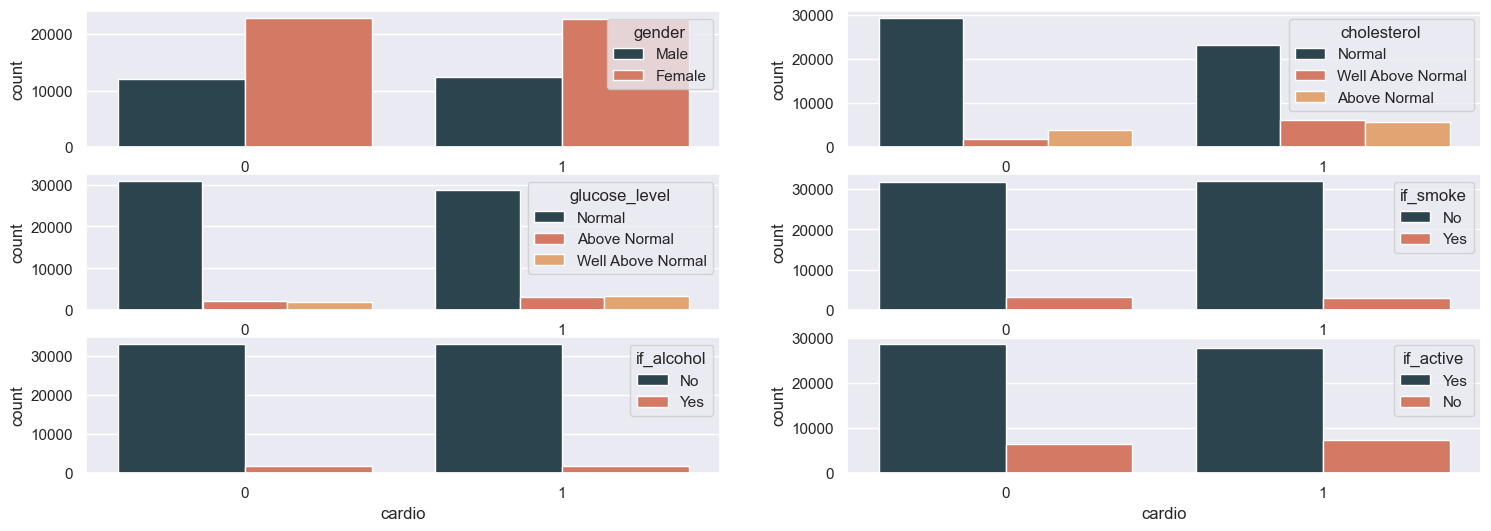

In [22]:
# Verifying categorical variables with target

plt.subplot( 3, 2, 1)
sns.countplot(x = 'cardio', hue ='gender', data= data_eda, palette=LAYOUT_PALETTE )

plt.subplot( 3, 2, 2)
sns.countplot(x = 'cardio', hue ='cholesterol', data= data_eda, palette=LAYOUT_PALETTE )

plt.subplot( 3, 2, 3)
sns.countplot(x = 'cardio', hue ='glucose_level', data= data_eda, palette=LAYOUT_PALETTE )

plt.subplot( 3, 2, 4)
sns.countplot(x = 'cardio', hue ='if_smoke', data= data_eda, palette=LAYOUT_PALETTE )

plt.subplot( 3, 2, 5)
sns.countplot(x = 'cardio', hue ='if_alcohol', data= data_eda, palette=LAYOUT_PALETTE )

plt.subplot( 3, 2, 6)
sns.countplot(x = 'cardio', hue ='if_active', data= data_eda, palette=LAYOUT_PALETTE )


### Multivaried Analysis : Categorical

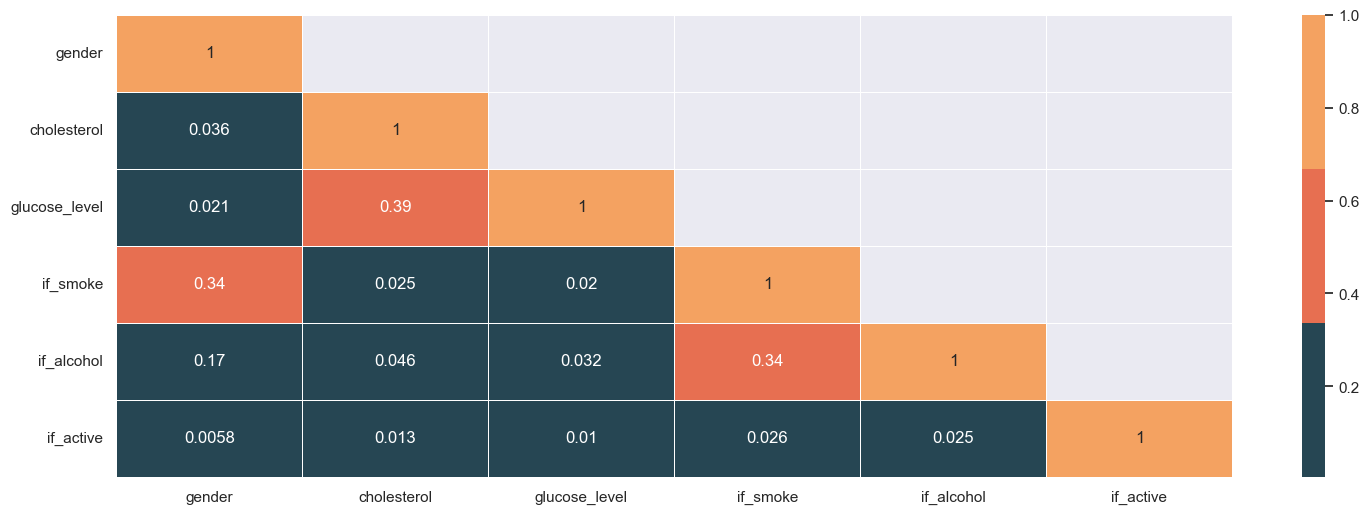

In [23]:
# only categorical data
a = data_eda.select_dtypes( include= 'object' )

# Calculate Cramer V
a1 = cramer_v(a['gender'], a['gender'])
a2 = cramer_v(a['gender'], a['cholesterol'])
a3 = cramer_v(a['gender'], a['glucose_level'])
a4 = cramer_v(a['gender'], a['if_smoke'])
a5 = cramer_v(a['gender'], a['if_alcohol'])
a6 = cramer_v(a['gender'], a['if_active'])

a7 = cramer_v(a['cholesterol'], a['gender'])
a8 = cramer_v(a['cholesterol'], a['cholesterol'])
a9 = cramer_v(a['cholesterol'], a['glucose_level'])
a10 = cramer_v(a['cholesterol'], a['if_smoke'])
a11 = cramer_v(a['cholesterol'], a['if_alcohol'])
a12 = cramer_v(a['cholesterol'], a['if_active'])

a13 = cramer_v(a['glucose_level'], a['gender'])
a14 = cramer_v(a['glucose_level'], a['cholesterol'])
a15 = cramer_v(a['glucose_level'], a['glucose_level'])
a16 = cramer_v(a['glucose_level'], a['if_smoke'])
a17 = cramer_v(a['glucose_level'], a['if_alcohol'])
a18 = cramer_v(a['glucose_level'], a['if_active'])

a19 = cramer_v(a['if_smoke'], a['gender'])
a20 = cramer_v(a['if_smoke'], a['cholesterol'])
a21 = cramer_v(a['if_smoke'], a['glucose_level'])
a22 = cramer_v(a['if_smoke'], a['if_smoke'])
a23 = cramer_v(a['if_smoke'], a['if_alcohol'])
a24 = cramer_v(a['if_smoke'], a['if_active'])

a25 = cramer_v(a['if_alcohol'], a['gender'])
a26 = cramer_v(a['if_alcohol'], a['cholesterol'])
a27 = cramer_v(a['if_alcohol'], a['glucose_level'])
a28 = cramer_v(a['if_alcohol'], a['if_smoke'])
a29 = cramer_v(a['if_alcohol'], a['if_alcohol'])
a30 = cramer_v(a['if_alcohol'], a['if_active'])

a31 = cramer_v(a['if_active'], a['gender'])
a32 = cramer_v(a['if_active'], a['cholesterol'])
a33 = cramer_v(a['if_active'], a['glucose_level'])
a34 = cramer_v(a['if_active'], a['if_smoke'])
a35 = cramer_v(a['if_active'], a['if_alcohol'])
a36 = cramer_v(a['if_active'], a['if_active'])
# Final dataset
d = pd.DataFrame( {'gender': [a1, a2, a3, a4, a5, a6],
               'cholesterol': [a7, a8, a9, a10, a11, a12],
               'glucose_level': [a13, a14, a15, a16, a17, a18],
               'if_smoke': [a19, a20, a21, a22, a23, a24],
               'if_alcohol': [a25, a26, a27, a28, a29, a30],
               'if_active': [a31, a32, a33, a34, a35, a36]})
d = d.set_index( d.columns )

mask = np.triu(np.ones_like(d), k=1)

sns.heatmap(d, annot=True , cmap= LAYOUT_PALETTE, mask=mask, linewidth=.5);

### Insights

- Most patients have good habits as no drinking, smoking and keeping an active routine of exercises
- Cholesterol has a positive correlation with cardiovascular disease
- Same goes for glucose level, both seem to contribute to a higher probability to have a cardio disease.

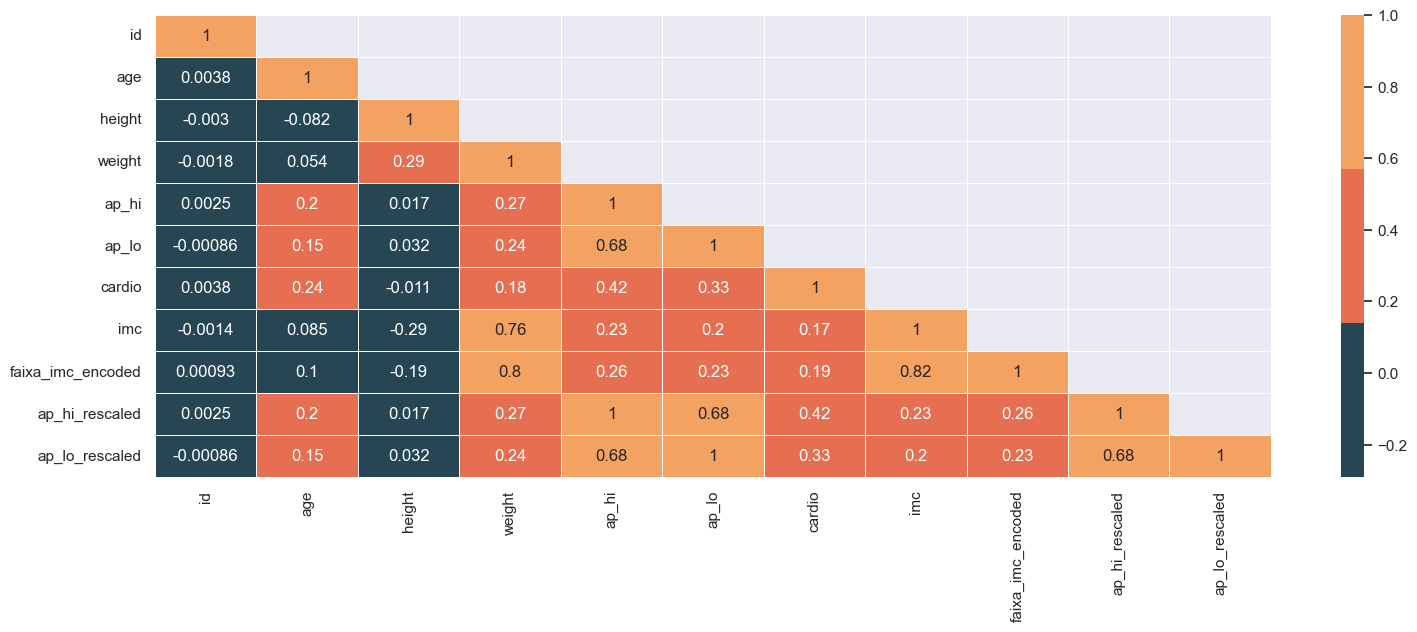

In [24]:
correlation = num_attributes.corr( method= 'pearson')

# getting upper triangle from correlation matrix
matrix = np.triu(correlation, k=1)

sns.heatmap( correlation, annot= True, mask= matrix, cmap= LAYOUT_PALETTE, linewidth=.5);

## Hypothesis Map

### H1. Pessoas mais velhas tendem a ter doença cardíaca - TRUE

**Verdadeiro** : pessoas mais velhas tem mais doença cardíaca do que jovens

<AxesSubplot:xlabel='age', ylabel='count'>

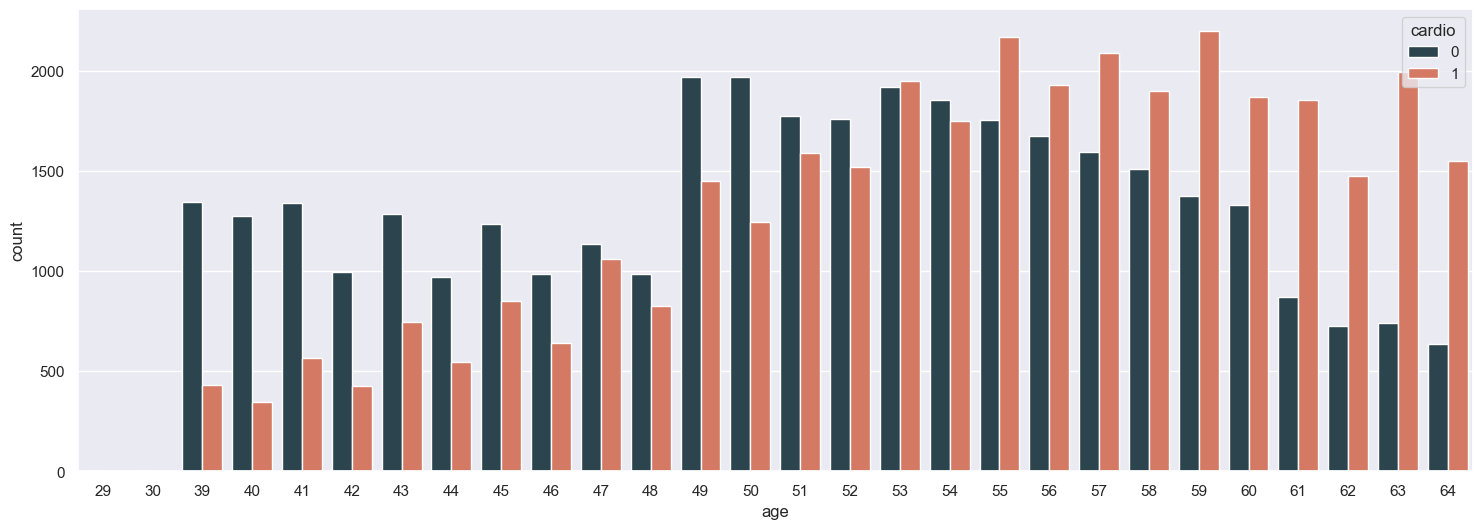

In [25]:
sns.countplot(x='age', hue='cardio', data= data_eda, palette=LAYOUT_PALETTE)

### H2. Fumantes tem mais doenças cardíacas que não fumantes - FALSE
**Indiferente** O fato de fumar não discrimina na doença cardíaca

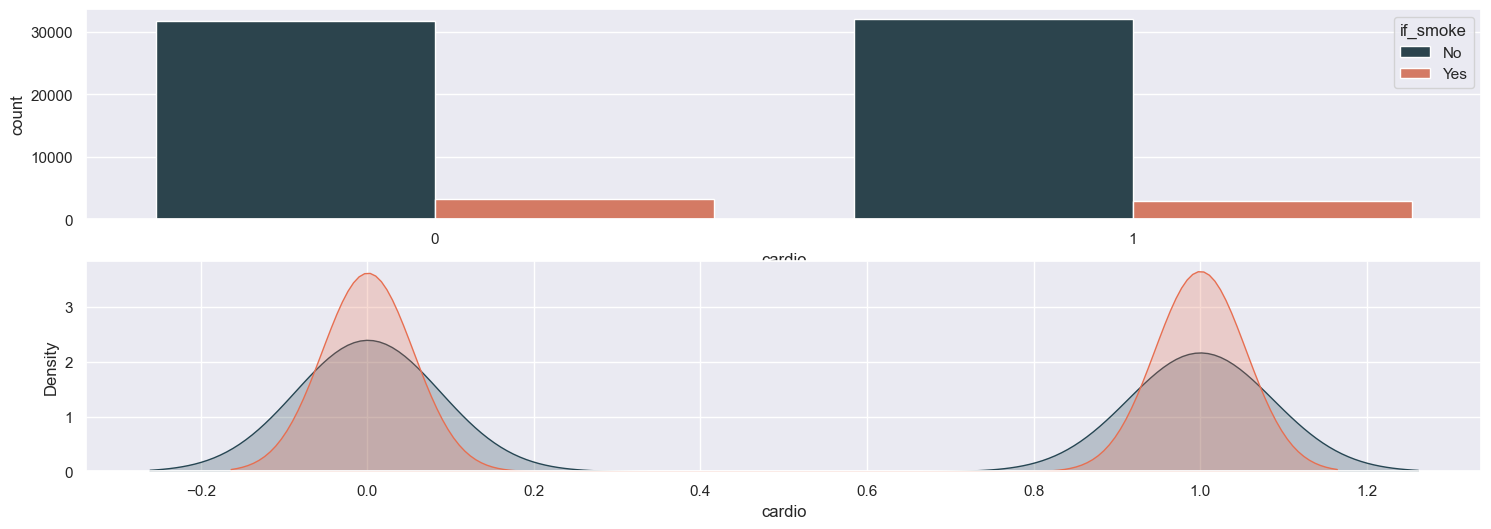

In [26]:
plt.subplot(2, 1, 1)
sns.countplot(x='cardio', hue='if_smoke', data= data_eda, palette=LAYOUT_PALETTE)

plt.subplot(2, 1, 2)
sns.kdeplot( data_eda[data_eda['if_smoke'] == 'Yes']['cardio'], fill=True, legend=True  ); 
sns.kdeplot( data_eda[data_eda['if_smoke']  == 'No']['cardio'], fill=True, legend=True );


### H3. Pessoas que não se exercitam tem mais doença cardíacas que ativos fisicamente - TRUE

**VERDADEIRO**: Pessoas que não se exercitam tem mais chance de apresentarem doenças cardíacas

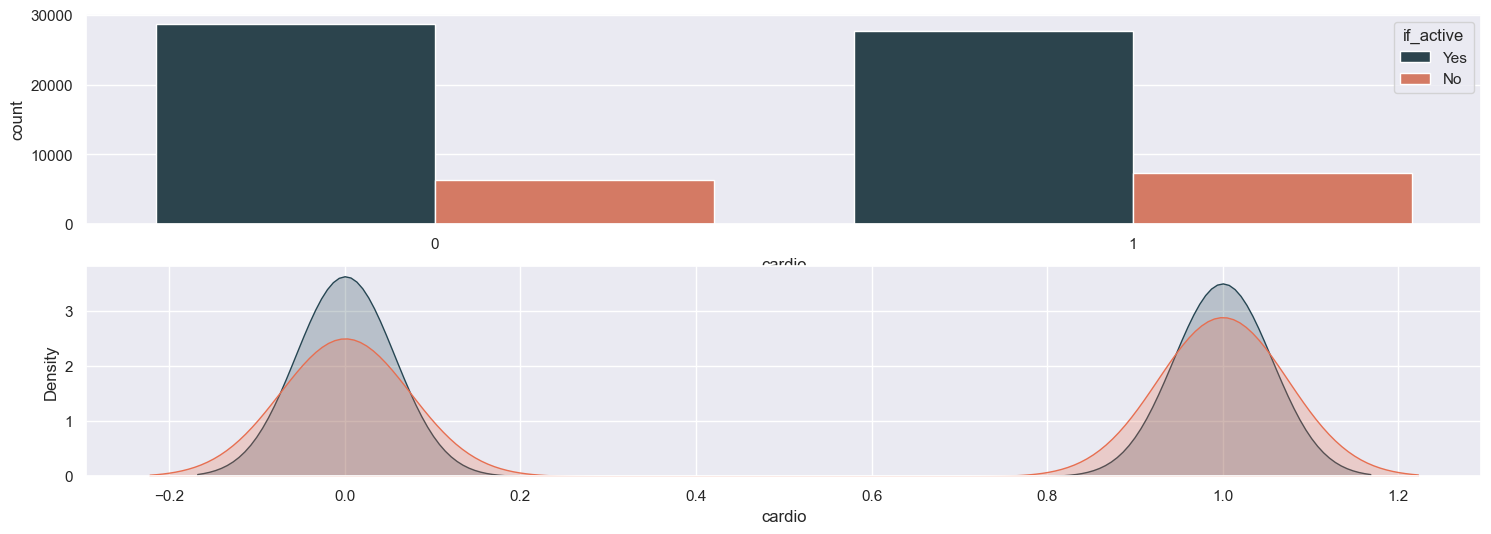

In [27]:
plt.subplot(2, 1, 1)
sns.countplot(x='cardio', hue='if_active', data= data_eda, palette=LAYOUT_PALETTE)

plt.subplot(2, 1, 2)
sns.kdeplot( data_eda[data_eda['if_active'] == 'Yes']['cardio'], fill=True, legend=True  )
sns.kdeplot( data_eda[data_eda['if_active']  == 'No']['cardio'], fill=True, legend=True );


#plt.subplot(3, 1, 3)
#sns.kdeplot( data_eda[data_eda['if_active'] == 'No']['cardio'], fill=True, legend=True  ); 
#sns.kdeplot( data_eda[data_eda['if_active'] == 'Yes']['cardio'], fill=True, legend=True );

### H4. Pessoas mais altas tem mais doenças cardíacas - FALSE

**FALSO** Não podemos afirmar que pessoas mais altas tem mais doenças cardíacas que as mais altas.

In [28]:
altura_aux = data_eda[data_eda['height'] > 140]
data_eda['faixa_altura'] = pd.cut(altura_aux['height'], 6, ordered=True)
data_eda.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,glucose_level,if_smoke,if_alcohol,if_active,cardio,imc,faixa_imc,faixa_imc_encoded,ap_hi_rescaled,ap_lo_rescaled,faixa_altura
0,0,50,Male,168,62.0,110.0,80.0,Normal,Normal,No,No,Yes,0,21.967120,normal,0.401318,-0.5,0.0,"(159.167, 177.333]"
1,1,55,Female,156,85.0,140.0,90.0,Well Above Normal,Normal,No,No,Yes,1,34.927679,obesidade_1,0.604160,1.0,1.0,"(140.891, 159.167]"
2,2,51,Female,165,64.0,130.0,70.0,Well Above Normal,Normal,No,No,No,1,23.507805,normal,0.401318,0.5,-1.0,"(159.167, 177.333]"
3,3,48,Male,169,82.0,150.0,100.0,Normal,Normal,No,No,Yes,1,28.710479,acima_peso,0.510085,1.5,2.0,"(159.167, 177.333]"
4,4,47,Female,156,56.0,100.0,60.0,Normal,Normal,No,No,No,0,23.011177,normal,0.401318,-1.0,-2.0,"(140.891, 159.167]"


C:\Users\Pichau\anaconda3\lib\site-packages\seaborn\distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


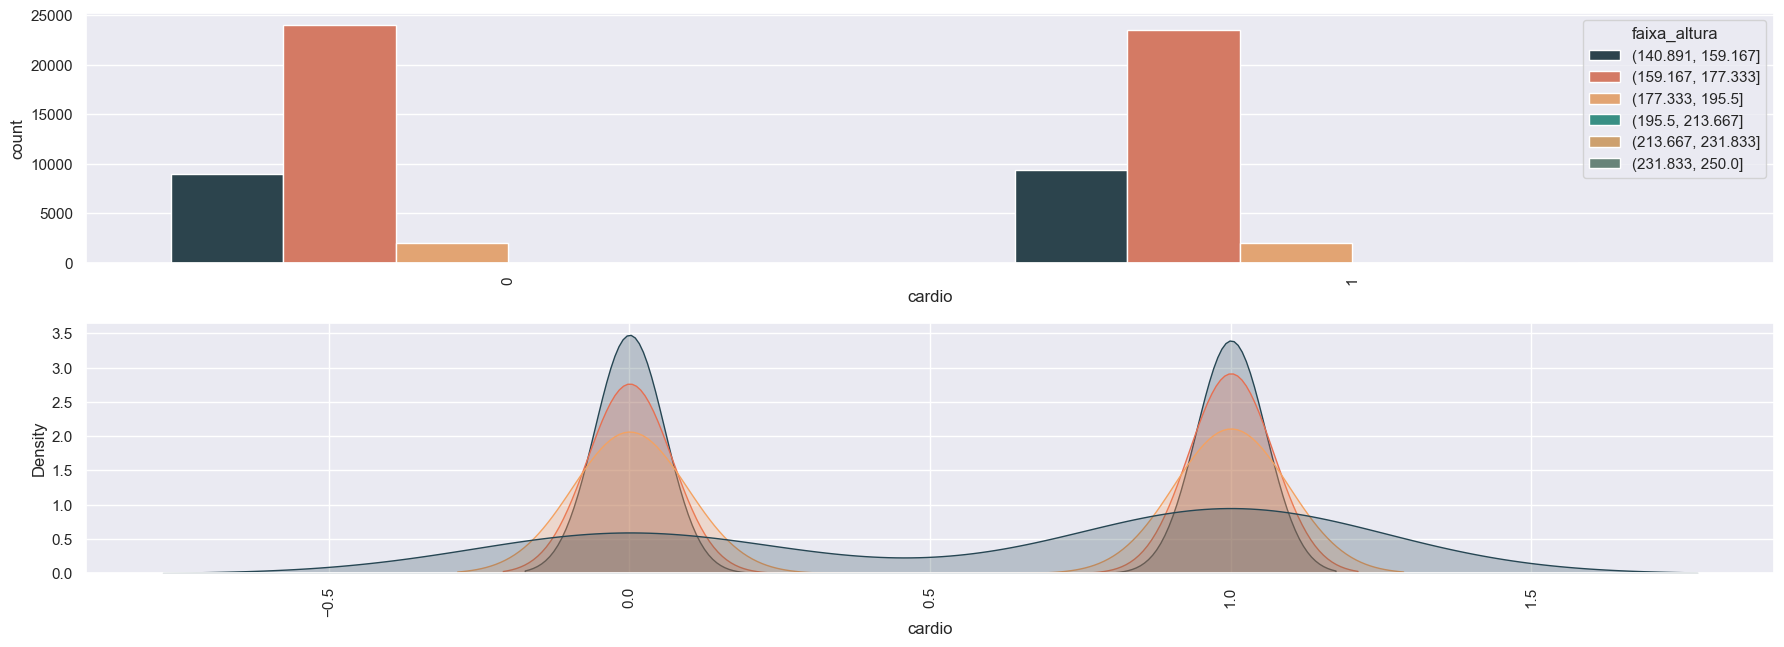

In [29]:
plt.subplot(2, 1, 1)
sns.countplot(x='cardio', hue='faixa_altura', data= data_eda, palette=LAYOUT_PALETTE2)
plt.xticks(rotation=90)
plt.tight_layout()

plt.subplot(2, 1, 2)
for i in data_eda['faixa_altura'].values.unique():
    sns.kdeplot( data_eda[data_eda['faixa_altura'] == i]['cardio'], fill=True, legend=True  ); 
plt.xticks(rotation=90);

### H5. Pessoas mais pesadas tem mais doenças cardíacas

**VERDADEIRO** A partir de 75kg, as pessoas tem mais tendência de apresentar doenças cardíacas

<AxesSubplot:xlabel='cardio', ylabel='count'>

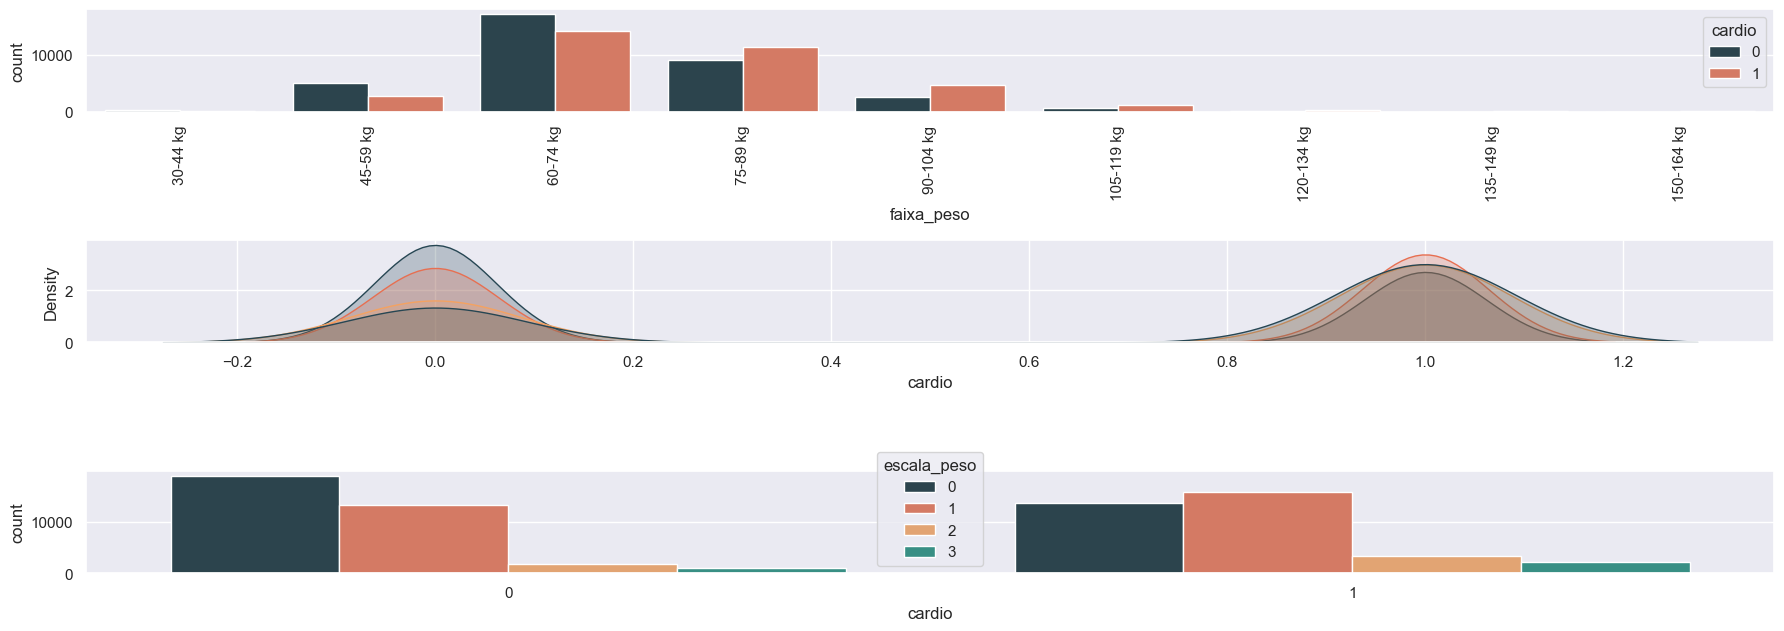

In [30]:
# Criar faixas de peso a cada 5 kg
faixas_peso = range(30, 180, 15)

# Criar rótulos para as faixas
rotulos_faixas = [f'{inicio}-{inicio+14} kg' for inicio in faixas_peso[:-1]]

# Aplicar pd.cut para criar a coluna de faixas de peso
data_eda['faixa_peso'] = pd.cut(data_eda['weight'], bins=faixas_peso, labels=rotulos_faixas, right=False)

# Verificar a contagem de valores em cada faixa
contagem_por_faixa = data_eda['faixa_peso'].value_counts().sort_index()

#plt.subplot(2, 2, 1)
plt.subplot2grid((3, 2), (0, 0), colspan=2)
sns.countplot(x='faixa_peso', hue='cardio', data= data_eda)
plt.xticks(rotation=90);
      
#plt.subplot(2, 2, 3)
plt.subplot2grid((3, 2), (1, 0), colspan=2)
data_eda['escala_peso'] = data_eda['weight'].apply(lambda x: 0 if x <= 70 else 1 if x <= 90 else 2 if x <= 100 else 3)

sns.kdeplot(data_eda[data_eda['escala_peso'] == 0]['cardio'], fill=True, legend=False)
sns.kdeplot(data_eda[data_eda['escala_peso'] == 1]['cardio'], fill=True, legend=False)
sns.kdeplot(data_eda[data_eda['escala_peso'] == 2]['cardio'], fill=True, legend=False)
sns.kdeplot(data_eda[data_eda['escala_peso'] == 3]['cardio'], fill=True, legend=False)

plt.tight_layout()
                 
plt.subplot2grid((3, 2), (2, 0), colspan=2)
sns.countplot(x='cardio', hue='escala_peso', data= data_eda, palette=LAYOUT_PALETTE2) 

#### H5.2 Pessoas com IMC elevado tem mais doenças cardíacas - TRUE
**VERDADEIRO** Pessoas com IMC considerado elevado tem mais tendência de apresentar doenças cardíacas.

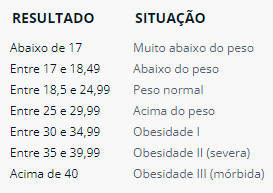

<AxesSubplot:xlabel='cardio', ylabel='Density'>

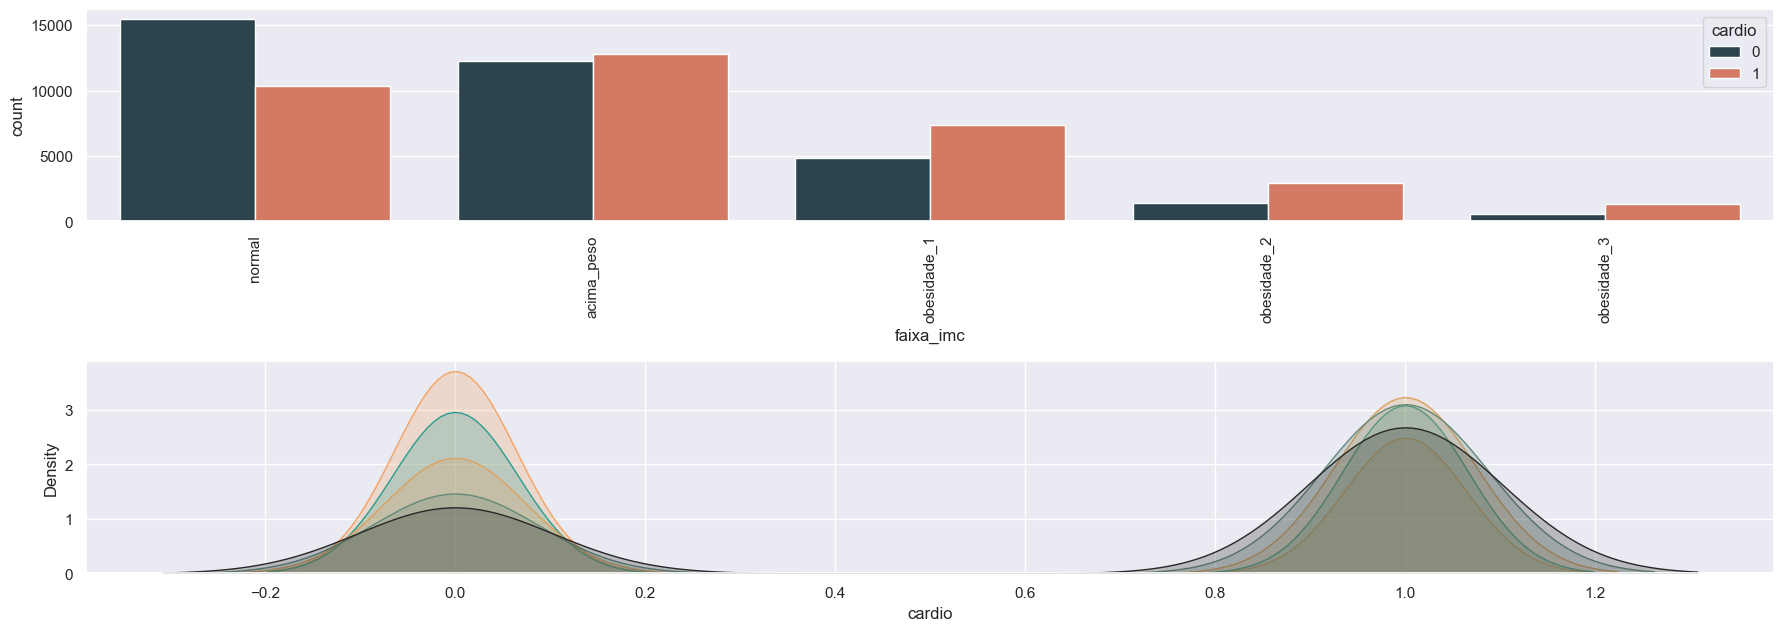

In [31]:
plt.subplot(2, 1, 1)
order = ['normal','acima_peso','obesidade_1','obesidade_2','obesidade_3']

sns.countplot(x='faixa_imc', hue='cardio', data= data_eda, palette=LAYOUT_PALETTE3,order=order)
plt.xticks(rotation=90)
plt.tight_layout()

plt.subplot(2, 1, 2)
#sns.kdeplot(data_eda[data_eda['faixa_imc'] == 'muito_abaixo_peso']['cardio'], fill=True, legend=False, color='#264653')
#sns.kdeplot(data_eda[data_eda['faixa_imc'] == 'abaixo_peso']['cardio'], fill=True, legend=False, color='#e76f51')
sns.kdeplot(data_eda[data_eda['faixa_imc'] == 'normal']['cardio'], fill=True, legend=False, color='#f4a261')
sns.kdeplot(data_eda[data_eda['faixa_imc'] == 'acima_peso']['cardio'], fill=True, legend=False, color='#2a9d8f')
sns.kdeplot(data_eda[data_eda['faixa_imc'] == 'obesidade_1']['cardio'], fill=True, legend=False, color='#dda15e')
sns.kdeplot(data_eda[data_eda['faixa_imc'] == 'obesidade_2']['cardio'], fill=True, legend=False, color='#63897a')
sns.kdeplot(data_eda[data_eda['faixa_imc'] == 'obesidade_3']['cardio'], fill=True, legend=False, color='#282828')

# LAYOUT_PALETTE3 = ["#264653", "#e76f51", "#f4a261", "#2a9d8f", "#dda15e", "#63897a", "#282828" ]

### H6. Pessoas com pressões mais altas tem mais doenças cardíacas

**VERDADEIRO**: pessoas com pressões elevadas (acima de 120 ap_hi e 80 ap_lo) tendem a ter mais doenças cardíacas

In [32]:
# using info from American Heart Association:

data_eda['status_ap_hi'] = data_eda['ap_hi'].apply( lambda x: 'normal' if x <= 120
                                                  else 'elevated' if x <= 129
                                                  else 'high_pressure_I' if x <= 139
                                                  else 'high_pressure_II' if x <= 180
                                                  else 'hypertensive')

data_eda['status_ap_lo'] = data_eda['ap_lo'].apply( lambda x: 'normal' if x <= 80
                                                  else 'high_pressure_I' if x <= 89
                                                  else 'high_pressure_II' if x <= 120
                                                  else 'hypertensive')

In [33]:
data_eda.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,glucose_level,if_smoke,if_alcohol,if_active,cardio,imc,faixa_imc,faixa_imc_encoded,ap_hi_rescaled,ap_lo_rescaled,faixa_altura,faixa_peso,escala_peso,status_ap_hi,status_ap_lo
0,0,50,Male,168,62.0,110.0,80.0,Normal,Normal,No,No,Yes,0,21.967120,normal,0.401318,-0.5,0.0,"(159.167, 177.333]",60-74 kg,0,normal,normal
1,1,55,Female,156,85.0,140.0,90.0,Well Above Normal,Normal,No,No,Yes,1,34.927679,obesidade_1,0.604160,1.0,1.0,"(140.891, 159.167]",75-89 kg,1,high_pressure_II,high_pressure_II
2,2,51,Female,165,64.0,130.0,70.0,Well Above Normal,Normal,No,No,No,1,23.507805,normal,0.401318,0.5,-1.0,"(159.167, 177.333]",60-74 kg,0,high_pressure_I,normal
3,3,48,Male,169,82.0,150.0,100.0,Normal,Normal,No,No,Yes,1,28.710479,acima_peso,0.510085,1.5,2.0,"(159.167, 177.333]",75-89 kg,1,high_pressure_II,high_pressure_II
4,4,47,Female,156,56.0,100.0,60.0,Normal,Normal,No,No,No,0,23.011177,normal,0.401318,-1.0,-2.0,"(140.891, 159.167]",45-59 kg,0,normal,normal


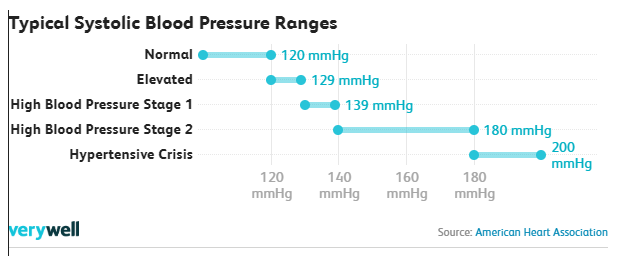

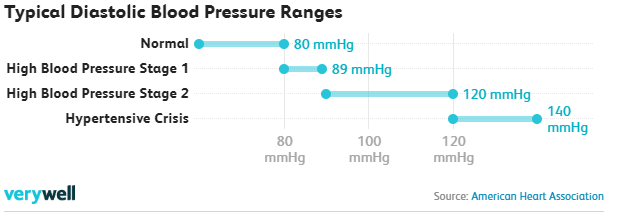

<AxesSubplot:xlabel='cardio', ylabel='Density'>

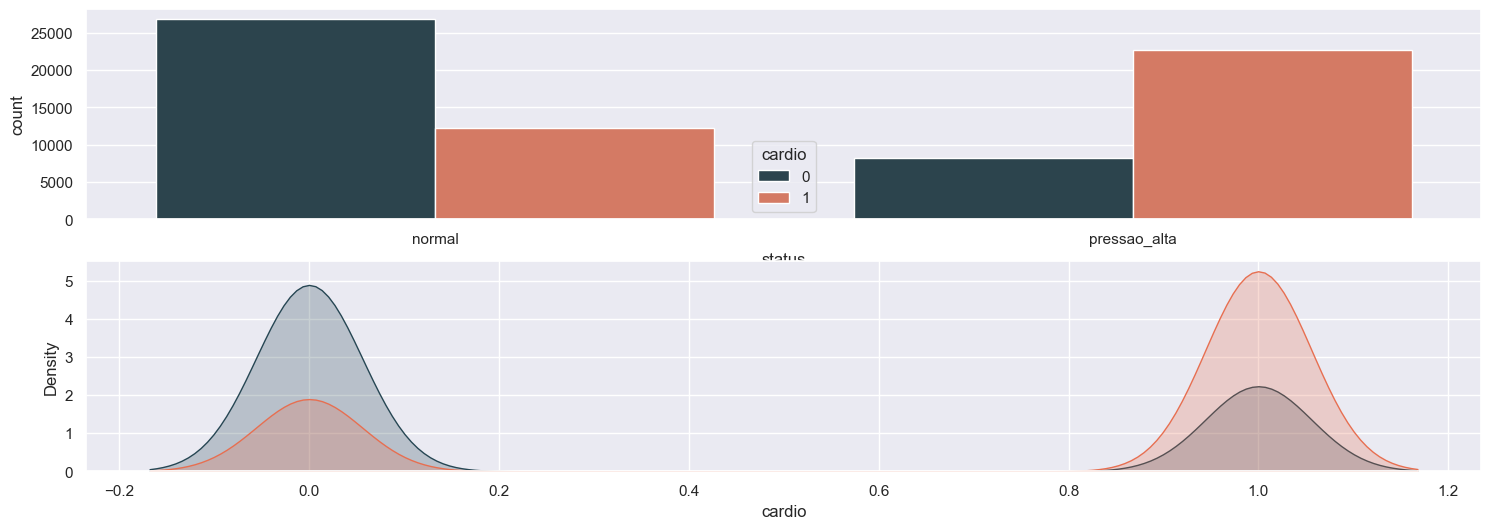

In [34]:
data_eda['status'] = data_eda.apply( lambda x: 'normal' if ((x['status_ap_hi'] == 'normal') &(x['status_ap_lo'] == 'normal')) else 'pressao_alta', axis=1)

plt.subplot(2, 1, 1)
sns.countplot(x='status', hue='cardio', data= data_eda, palette=LAYOUT_PALETTE2);

plt.subplot(2, 1, 2)
sns.kdeplot(data_eda[data_eda['status'] == 'normal']['cardio'], fill=True, legend=False)
sns.kdeplot(data_eda[data_eda['status'] == 'pressao_alta']['cardio'], fill=True, legend=False)


### H7. Pessoas com pressão negativa tem mais doenças cardíacas - FALSE
**FALSO** Apesar de haver casos de pressão negativa em diagnósticos, são bem específicos e deveriam ser característicos de algumas condições que implicam em doenças cardíacas. No caso desses dados no qual nem todos os pacientes que apresentaram pressão arterial negativa apresentaram doença cardíaca, podemos especular que se tratam de typos.

In [35]:
data_eda.columns

Index(['id', 'age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo',
       'cholesterol', 'glucose_level', 'if_smoke', 'if_alcohol', 'if_active',
       'cardio', 'imc', 'faixa_imc', 'faixa_imc_encoded', 'ap_hi_rescaled',
       'ap_lo_rescaled', 'faixa_altura', 'faixa_peso', 'escala_peso',
       'status_ap_hi', 'status_ap_lo', 'status'],
      dtype='object')

In [36]:
data_eda['cardio_neg'] = data_eda.apply(lambda x: 1 if (x['ap_hi'] < 0 or x['ap_lo'] < 0 ) else 0, axis=1)

#data_eda[(data_eda['ap_hi'] < 0) | (data_eda['ap_lo'] < 0)]

In [37]:
h7.head()

NameError: name 'h7' is not defined

In [ ]:
sns.countplot(x='cardio_neg', hue='cardio', data= data_eda)
plt.xticks(rotation=90)

## <div style="color:white;display:fill;border-radius:5px;background-color:#264653;letter-spacing:0.5px;overflow:hidden"><p style="padding:20px;color:white;overflow:hidden;text-align: center;margin:0;font-size:120%">Feature Engineering</p></div>

In [45]:
df_prep = df_preprocessing.copy()

In [46]:
# changing gender to 0 and 1 (0 female, 1 male )
df_prep['gender'] = df_prep['gender'].apply( lambda x : 0 if x == 1 else 1)


## <div style="color:white;display:fill;border-radius:5px;background-color:#264653;letter-spacing:0.5px;overflow:hidden"><p style="padding:20px;color:white;overflow:hidden;text-align: center;margin:0;font-size:120%">Data Preparation</p></div>

In [163]:
train_raw, test_raw = train_test_split(df_prep, test_size=0.15, random_state=42)

# Imprimindo o tamanho dos conjuntos de treino, validação e teste
print(f"Tamanho do conjunto de treino: {train_raw.shape}")
print(f"Tamanho do conjunto de teste: {test_raw.shape}")

Tamanho do conjunto de treino: (59500, 18)
Tamanho do conjunto de teste: (10500, 18)


In [48]:
df_prep.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,glucose_level,if_smoke,if_alcohol,if_active,cardio,imc,faixa_imc,faixa_imc_encoded,ap_hi_rescaled,ap_lo_rescaled
0,0,50,1,168,62.0,110.0,80.0,1,1,0,0,1,0,21.967120,normal,0.401318,-0.5,0.0
1,1,55,0,156,85.0,140.0,90.0,3,1,0,0,1,1,34.927679,obesidade_1,0.604160,1.0,1.0
2,2,51,0,165,64.0,130.0,70.0,3,1,0,0,0,1,23.507805,normal,0.401318,0.5,-1.0
3,3,48,1,169,82.0,150.0,100.0,1,1,0,0,1,1,28.710479,acima_peso,0.510085,1.5,2.0
4,4,47,0,156,56.0,100.0,60.0,1,1,0,0,0,0,23.011177,normal,0.401318,-1.0,-2.0


In [164]:
# After some tests, we had better results using BMI (imc) as it is, without encoding.
#X_train = train_raw.drop(['id','cardio', 'weight','height', 'imc', 'faixa_imc', 'ap_hi','ap_lo'], axis=1)
X_train = train_raw.drop(['id','cardio', 'weight','height', 'faixa_imc', 'faixa_imc_encoded', 'ap_hi_rescaled', 'ap_lo_rescaled'], axis=1)
y_train = train_raw['cardio']

X_test = test_raw.drop(['id','cardio', 'weight','height', 'faixa_imc', 'faixa_imc_encoded', 'ap_hi_rescaled', 'ap_lo_rescaled'], axis=1)
y_test = test_raw['cardio']

In [144]:
X_train.head()

,age,gender,ap_hi,ap_lo,cholesterol,glucose_level,if_smoke,if_alcohol,if_active,imc
61847,48,1,140.0,80.0,1,1,0,0,1,34.717839
18028,59,0,110.0,70.0,1,1,0,0,1,22.038567
12586,56,0,120.0,80.0,1,1,0,0,1,23.661439
33612,55,0,120.0,80.0,1,1,0,0,1,28.875440
38926,54,0,110.0,60.0,1,1,0,0,1,25.148605


In [145]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((59500, 10), (59500,), (10500, 10), (10500,))

## <div style="color:white;display:fill;border-radius:5px;background-color:#264653;letter-spacing:0.5px;overflow:hidden"><p style="padding:20px;color:white;overflow:hidden;text-align: center;margin:0;font-size:120%">Models</p></div>

In [51]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score

In [52]:
# O que vamos testar?

Baseline (aleatório)
Logistic Regression
XGBoost
LightGBM
KNN Classifier
SVM

SyntaxError: invalid syntax (3720924079.py, line 4)

In [53]:
# Cross validation
def CVS( model_name, model, training, kfold, verbose=False):
    xtraining = training.drop(['id','cardio', 'weight','height', 'faixa_imc', 'faixa_imc_encoded', 'ap_hi_rescaled', 'ap_lo_rescaled'], axis=1)
    ytraining = training['cardio']
        
    # model
    m = model.fit( xtraining, ytraining )
    
    accuracy_scores = cross_val_score(m, xtraining, ytraining, cv=kfold, scoring='accuracy')
    precision_scores = cross_val_score(m, xtraining, ytraining, cv=kfold, scoring='precision')
    recall_scores = cross_val_score(m, xtraining, ytraining, cv=kfold, scoring='recall')
    f1_scores = cross_val_score(m, xtraining, ytraining, cv=kfold, scoring='f1')
    
    mydict = {'Accuracy': round(accuracy_scores.mean(),3), 'Precision': round(precision_scores.mean(),3), 'Recall': round(recall_scores.mean(),3), 'F1 Score': round(f1_scores.mean(),3)}

    df_results = pd.DataFrame(data=mydict, index=[model_name]);

    return df_results

## Baseline

In [54]:
yhat_base_test = np.random.choice([0,1], size= y_test.shape[0])

accuracy_base_test = accuracy_score(y_test, yhat_base_test)
print(f"\nAcurácia nos dados de teste: {accuracy_base_test:.2f}")

precision_base_test = precision_score( y_test, yhat_base_test)
print(f'Precisão nos dados de teste: {precision_base_test:.2f}')

f1_base_test = f1_score( y_test,yhat_base_test)
print(f'F1-Score dos dados de teste: {f1_base_test:.2f}')


Acurácia nos dados de teste: 0.50
Precisão nos dados de teste: 0.50
F1-Score dos dados de teste: 0.50


## Logistic Regression

In [55]:
# model
lr = LogisticRegression().fit(X_train, y_train)

# predicion
yhat_lr = lr.predict( X_test )

# performance
lr_accuracy_score = round(accuracy_score( y_test, yhat_lr ),3)
lr_precision_score = round(precision_score( y_test, yhat_lr ),3)
lr_recall_score = round(recall_score( y_test, yhat_lr),3)
lr_f1 = round(f1_score(y_test, yhat_lr),3)

lr_dict = {'Accuracy': lr_accuracy_score, 'Precision': lr_precision_score, 'Recall': lr_recall_score, 'F1 Score': lr_f1}
df_lr = pd.DataFrame(data=lr_dict, index=['Logistic Regression'])

C:\Users\Pichau\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


#### Logistic Regression - Cross Validation

In [56]:
df_lr_CV = CVS('Logistic Regression CV', lr , train_raw, kfold=5, verbose=False);

C:\Users\Pichau\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Pichau\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_ite

C:\Users\Pichau\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Pichau\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_ite

In [57]:
df_lr , df_lr_CV

(                     Accuracy  Precision  Recall  F1 Score
 Logistic Regression     0.698      0.712   0.669      0.69,
                         Accuracy  Precision  Recall  F1 Score
 Logistic Regression CV     0.715      0.734   0.674     0.703)

## XGBoost

In [58]:
import xgboost as xgb

In [59]:
# Crie o modelo XGBoost
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',  # Para problemas de classificação binária
    n_estimators=100,             # Número de árvores (estimadores)
    max_depth=3,                  # Profundidade máxima das árvores
    learning_rate=0.1,            # Taxa de aprendizado
    random_state=42               # Semente aleatória para reprodutibilidade
)

# Treine o modelo
xgboost = xgb_model.fit(X_train, y_train)

yhat_xgb = xgboost.predict( X_test )

# performance
xgb_accuracy_score = round(accuracy_score( y_test, yhat_xgb ),3)
xgb_precision_score = round(precision_score( y_test, yhat_xgb ),3)
xgb_recall_score = round(recall_score( y_test, yhat_xgb),3)
xgb_f1 = round(f1_score(y_test, yhat_xgb),3)

xgb_dict = {'Accuracy': xgb_accuracy_score, 'Precision': xgb_precision_score, 'Recall': xgb_recall_score, 'F1 Score': xgb_f1}
df_xgb = pd.DataFrame(data=xgb_dict, index=['XGBoost'])

df_xgb

,Accuracy,Precision,Recall,F1 Score
XGBoost,0.742,0.764,0.703,0.732


#### XGBoost - Cross Validation

In [60]:
df_xgb_CV = CVS('XGBoost CV', xgb_model , train_raw, kfold=5, verbose=False);

In [61]:
df_xgb , df_xgb_CV

(         Accuracy  Precision  Recall  F1 Score
 XGBoost     0.742      0.764   0.703     0.732,
             Accuracy  Precision  Recall  F1 Score
 XGBoost CV     0.735      0.755   0.696     0.724)

## LightGBM

In [62]:
import lightgbm as lgb
from lightgbm import early_stopping, log_evaluation

In [63]:
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test)


In [64]:
params = {
    'objective': 'binary',   # Definir o tipo de problema como binário
    'metric': 'binary_logloss',  # Métrica de avaliação
    'boosting_type': 'gbdt',  # Tipo de boosting (Gradient Boosting Decision Tree)
    'num_leaves': 31,         # Número máximo de folhas em uma árvore
    'learning_rate': 0.05,    # Taxa de aprendizado
    'feature_fraction': 0.9,  # Fração de características usadas para treinamento de cada árvore
    'bagging_fraction': 0.8,  # Fração de amostras usadas para treinamento de cada árvore
    'bagging_freq': 5,        # Frequência de amostragem
    'verbose': 0             # Controle da saída durante o treinamento
}


In [65]:
#colsample_bytree': 0.65,
#'learning_rate': 0.005,
#'n_estimators': 40,
#'num_boost_round': 3000,
#'num_leaves': 16,
#'random_state': 501,
#'reg_alpha': 1,
#'reg_lambda': 1.2,
#'subsample': 0.7}

In [66]:
num_round = 100  # Número de rodadas (iterações)
lgbm_model = lgb.train(params, train_data, num_round, valid_sets=[test_data])

yhat_lgbm = lgbm_model.predict(X_test, num_iteration=lgbm_model.best_iteration)  # Fazer previsões
yhat_binary_lgbm = [1 if pred > 0.5 else 0 for pred in yhat_lgbm]  # Converter probabilidades em classes binárias

# performance
lgbm_accuracy_score = round(accuracy_score( y_test, yhat_binary_lgbm ),5)
lgbm_precision_score = round(precision_score( y_test, yhat_binary_lgbm ),5)
lgbm_recall_score = round(recall_score( y_test, yhat_binary_lgbm),5)
lgbm_f1 = round(f1_score(y_test, yhat_binary_lgbm),5)

lgbm_dict = {'Accuracy': lgbm_accuracy_score, 'Precision': lgbm_precision_score, 'Recall': lgbm_recall_score, 'F1 Score': lgbm_f1}
df_lgbm = pd.DataFrame(data=lgbm_dict, index=['LightGBM'])

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002524 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


In [67]:
df_lgbm

,Accuracy,Precision,Recall,F1 Score
LightGBM,0.74124,0.76561,0.69932,0.73096


#### LightGBM - Cross Validation

In [68]:
# lgbm tem um módulo próprio para cross validation
cv_results = lgb.cv(params, train_data, num_boost_round=1000, nfold=5, stratified=True, callbacks=[early_stopping(100), log_evaluation(100)])

# Encontre o melhor número de iterações
#best_num_iterations = len(cv_results['binary_logloss'])

# Treine o modelo com o número ideal de iterações
lgbm_cv = lgb.train(params, train_data, num_boost_round=1000)

# Use o modelo para fazer previsões
yhat_lgbm_cv = lgbm_model.predict(X_test)

yhat_binary_lgbm_cv = [1 if pred > 0.5 else 0 for pred in yhat_lgbm_cv]  # Converter probabilidades em classes binárias

# performance
lgbm_accuracy_score_cv = round(accuracy_score( y_test, yhat_binary_lgbm_cv ),5)
lgbm_precision_score_cv = round(precision_score( y_test, yhat_binary_lgbm_cv ),5)
lgbm_recall_score_cv = round(recall_score( y_test, yhat_binary_lgbm_cv),5)
lgbm_f1_cv = round(f1_score(y_test, yhat_binary_lgbm_cv),5)

lgbm_dict_cv = {'Accuracy': lgbm_accuracy_score_cv, 'Precision': lgbm_precision_score_cv, 'Recall': lgbm_recall_score_cv, 'F1 Score': lgbm_f1_cv}
df_lgbm_cv = pd.DataFrame(data=lgbm_dict_cv, index=['LightGBM CV'])

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001032 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000968 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001095 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001208 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing

#### LightGBM - GridSearchCV

In [69]:
from sklearn.model_selection import GridSearchCV

In [70]:
train_raw, valid_raw = train_test_split(train_raw, test_size=0.15, random_state=42)

X_train_lgbm = train_raw.drop(['id','cardio', 'weight','height', 'faixa_imc', 'faixa_imc_encoded', 'ap_hi_rescaled', 'ap_lo_rescaled'], axis=1)
y_train_lgbm = train_raw['cardio']

X_valid_lgbm = valid_raw.drop(['id','cardio', 'weight','height', 'faixa_imc', 'faixa_imc_encoded', 'ap_hi_rescaled', 'ap_lo_rescaled'], axis=1)
y_valid_lgbm = valid_raw['cardio']

In [71]:
gridParams = { 
    'learning_rate': [0.005, 0.05, 0.01, 0.1],
    'n_estimators': [40],
    'num_leaves': [16, 32, 50, 64, 100], 
    'random_state' : [501],
    'num_boost_round' : [3000],
    'colsample_bytree' : [0.65, 0.66],
    'subsample' : [0.7,0.75],
    'reg_alpha' : [0.05, 0.075, 1, 1.2],
    'reg_lambda' : [0.05, 0.075, 1, 1.2, 1.4], 
    }

lgb_estimator = lgb.LGBMClassifier(boosting_type = 'gbdt', 
                                   n_estimators=500, 
                                   learning_rate =  0.05, num_leaves =  64,  
                                   early_stopping_rounds=10)

g_lgbm = GridSearchCV(estimator=lgb_estimator, param_grid=gridParams, n_jobs = 3, cv= 3)

lgb_model = g_lgbm.fit(X=X_train_lgbm, y=y_train_lgbm, eval_set = (X_valid_lgbm, y_valid_lgbm))

yhat_lgb_model = lgb_model.predict(X_test)

yhat_binary_lgb_model_cv = [1 if pred > 0.5 else 0 for pred in yhat_lgb_model]

# performance
lgb_model_accuracy_score_cv = round(accuracy_score( y_test, yhat_binary_lgb_model_cv ),5)
lgb_model_precision_score_cv = round(precision_score( y_test, yhat_binary_lgb_model_cv ),5)
lgb_model_recall_score_cv = round(recall_score( y_test, yhat_binary_lgb_model_cv),5)
lgb_model_f1_cv = round(f1_score(y_test, yhat_binary_lgb_model_cv),5)

lgb_model_dict_cv = {'Accuracy': lgb_model_accuracy_score_cv, 'Precision': lgb_model_precision_score_cv, 'Recall': lgb_model_recall_score_cv, 'F1 Score': lgb_model_f1_cv}
df_lgb_model_cv = pd.DataFrame(data=lgb_model_dict_cv, index=['LightGBM CV - Grid'])

C:\Users\Pichau\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] early_stopping_round is set=10, early_stopping_rounds=10 will be ignored. Current value: early_stopping_round=10
[LightGBM] [Warning] num_iterations is set=3000, num_boost_round=3000 will be ignored. Current value: num_iterations=3000
[LightGBM] [Info] Number of positive: 25246, number of negative: 25329
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001454 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 478
[LightGBM] [Info] Number of data points in the train set: 50575, number of used features: 10
[LightGBM] [Warning] early_stopping_round is set=10, early_stopping_rounds=10 will be ignored. Current value: early_stopping_round=10
[LightGBM] [Warning] num_iterations is set=3000, num_boost_round=3000 will be ignored. Current value: num_iterations=3000
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499179 -> in

In [72]:
lgb_model.best_params_

{'colsample_bytree': 0.65,
 'learning_rate': 0.01,
 'n_estimators': 40,
 'num_boost_round': 3000,
 'num_leaves': 32,
 'random_state': 501,
 'reg_alpha': 1.2,
 'reg_lambda': 1,
 'subsample': 0.7}

In [73]:
df_lgbm, df_lgbm_cv, df_lgb_model_cv

(          Accuracy  Precision   Recall  F1 Score
 LightGBM   0.74124    0.76561  0.69932   0.73096,
              Accuracy  Precision   Recall  F1 Score
 LightGBM CV   0.74124    0.76561  0.69932   0.73096,
                     Accuracy  Precision   Recall  F1 Score
 LightGBM CV - Grid   0.74295     0.7677  0.70064   0.73264)

In [74]:
df_results = pd.concat([ df_lr_CV, df_xgb_CV, df_lgbm_cv, df_lgb_model_cv], ignore_index=False)
df_results

,Accuracy,Precision,Recall,F1 Score
Logistic Regression CV,0.71500,0.73400,0.67400,0.70300
XGBoost CV,0.73500,0.75500,0.69600,0.72400
LightGBM CV,0.74124,0.76561,0.69932,0.73096
LightGBM CV - Grid,0.74295,0.76770,0.70064,0.73264


## KNN Classifier

In [75]:
from sklearn.neighbors import KNeighborsClassifier

In [76]:
knn_model = KNeighborsClassifier(n_neighbors=25)

knn_class = knn_model.fit(X_train, y_train)

yhat_knn = knn_class.predict(X_test)

C:\Users\Pichau\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


In [77]:
knn_accuracy_score = accuracy_score(y_test, yhat_knn)
knn_precision_score = precision_score(y_test, yhat_knn)
knn_recall_score = recall_score(y_test, yhat_knn)
knn_f1 = f1_score(y_test, yhat_knn)

knn_dict = {'Accuracy': knn_accuracy_score, 'Precision': knn_precision_score, 'Recall': knn_recall_score, 'F1 Score': knn_f1}
df_knn = pd.DataFrame(data=knn_dict, index=['KNN Classifier'])

df_knn

,Accuracy,Precision,Recall,F1 Score
KNN Classifier,0.725714,0.74948,0.682455,0.714399


#### KNN Classifier (K-Nearest Neighbours Classifier) - Cross Validation

In [78]:
df_knn_CV = CVS('KNN Classifier - CV', knn_model, train_raw, kfold=5, verbose=False );

df_knn_CV

C:\Users\Pichau\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\Pichau\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepd

C:\Users\Pichau\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\Pichau\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepd

,Accuracy,Precision,Recall,F1 Score
KNN Classifier - CV,0.723,0.745,0.678,0.71


## SVM

In [79]:
from sklearn.svm import SVC

In [80]:
# linear
svm_linear_model = SVC(kernel='linear')
svm_linear = svm_linear_model.fit(X_train, y_train)
yhat_svm_linear = svm_linear.predict(X_test)

svm_linear_accuracy_score = accuracy_score(y_test, yhat_svm_linear)
svm_linear_precision_score = precision_score(y_test, yhat_svm_linear)
svm_linear_recall_score = recall_score(y_test, yhat_svm_linear)
svm_linear_f1 = f1_score(y_test, yhat_svm_linear)

svm_linear_dict = {'Accuracy': svm_linear_accuracy_score, 'Precision': svm_linear_precision_score, 'Recall': svm_linear_recall_score, 'F1 Score': svm_linear_f1}
df_svm_linear = pd.DataFrame(data=svm_linear_dict, index=['SVM linear'])

In [81]:
# poly
svm_poly_model = SVC(kernel='poly')
svm_poly = svm_poly_model.fit(X_train, y_train)
yhat_svm_poly = svm_poly.predict(X_test)

svm_poly_accuracy_score = accuracy_score(y_test, yhat_svm_poly)
svm_poly_precision_score = precision_score(y_test, yhat_svm_poly)
svm_poly_recall_score = recall_score(y_test, yhat_svm_poly)
svm_poly_f1 = f1_score(y_test, yhat_svm_poly)

svm_poly_dict = {'Accuracy': svm_poly_accuracy_score, 'Precision': svm_poly_precision_score, 'Recall': svm_poly_recall_score, 'F1 Score': svm_poly_f1}
df_svm_poly = pd.DataFrame(data=svm_poly_dict, index=['SVM poly'])

In [82]:
# rbf
svm_rbf_model = SVC(kernel='rbf')
svm_rbf = svm_rbf_model.fit(X_train, y_train)
yhat_svm_rbf = svm_rbf.predict(X_test)

svm_rbf_accuracy_score = accuracy_score(y_test, yhat_svm_rbf)
svm_rbf_precision_score = precision_score(y_test, yhat_svm_rbf)
svm_rbf_recall_score = recall_score(y_test, yhat_svm_rbf)
svm_rbf_f1 = f1_score(y_test, yhat_svm_rbf)

svm_rbf_dict = {'Accuracy': svm_rbf_accuracy_score, 'Precision': svm_rbf_precision_score, 'Recall': svm_rbf_recall_score, 'F1 Score': svm_rbf_f1}
df_svm_rbf = pd.DataFrame(data=svm_rbf_dict, index=['SVM rbf'])

In [83]:
# sigmoidal

# Defina os valores que você deseja testar para coef0 e C
#param_grid = {
#    'coef0': [0.1, 0.2, 0.5],
#    'C': [0.1, 1, 10]
#}
#
## Crie o modelo SVM com kernel sigmoidal
#svm_sigmoidal_model = SVC(kernel='sigmoid', gamma='auto')
#
## Crie o objeto GridSearchCV
#grid_search = GridSearchCV(svm_sigmoidal_model, param_grid, cv=3, scoring='accuracy')
#
#svm_sigmoidal = grid_search.fit(X_train, y_train)
#
#best_params = grid_search.best_params_
#print("Melhores hiperparâmetros:", best_params)
#
## Use o melhor modelo para fazer previsões
#best_model = grid_search.best_estimator_
#yhat_svm_sigmoidal = best_model.predict(X_test)
#
#svm_sigmoidal_accuracy_score = accuracy_score(y_test, yhat_svm_sigmoidal)
#svm_sigmoidal_precision_score = precision_score(y_test, yhat_svm_sigmoidal)
#svm_sigmoidal_recall_score = recall_score(y_test, yhat_svm_sigmoidal)
#svm_sigmoidal_f1 = f1_score(y_test, yhat_svm_sigmoidal)
#
#svm_sigmoidal_dict = {'Accuracy': svm_sigmoidal_accuracy_score, 'Precision': svm_sigmoidal_precision_score, 'Recall': svm_sigmoidal_recall_score, 'F1 Score': svm_sigmoidal_f1}
#df_svm_sigmoidal = pd.DataFrame(data=svm_sigmoidal_dict, index=['SVM sigmoidal'])

In [84]:
#df_svm_compilado = pd.concat([df_svm_linear, df_svm_poly, df_svm_rbf ,df_svm_sigmoidal])
df_svm_compilado = pd.concat([df_svm_linear, df_svm_poly, df_svm_rbf])
#
df_svm_compilado



,Accuracy,Precision,Recall,F1 Score
SVM linear,0.727048,0.771377,0.649488,0.705205
SVM poly,0.727714,0.796083,0.616142,0.694649
SVM rbf,0.725429,0.778036,0.634900,0.699218


# Results

In [85]:
df_results_final = pd.concat([df_results, df_knn_CV, df_svm_compilado])

df_results_final

,Accuracy,Precision,Recall,F1 Score
Logistic Regression CV,0.715000,0.734000,0.674000,0.703000
XGBoost CV,0.735000,0.755000,0.696000,0.724000
LightGBM CV,0.741240,0.765610,0.699320,0.730960
LightGBM CV - Grid,0.742950,0.767700,0.700640,0.732640
KNN Classifier - CV,0.723000,0.745000,0.678000,0.710000
SVM linear,0.727048,0.771377,0.649488,0.705205
SVM poly,0.727714,0.796083,0.616142,0.694649
SVM rbf,0.725429,0.778036,0.634900,0.699218


In [148]:
X_train.shape

(59500, 10)

In [149]:
y_test.shape

(10500,)

In [150]:
baseline
logistic regression
xgb
lgbm - grid

SyntaxError: invalid syntax (4219268058.py, line 2)

### ROC Curve to evaluate models

[LightGBM] [Info] Number of positive: 29701, number of negative: 29799
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001323 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 482
[LightGBM] [Info] Number of data points in the train set: 59500, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499176 -> initscore=-0.003294
[LightGBM] [Info] Start training from score -0.003294


C:\Users\Pichau\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Pichau\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid t

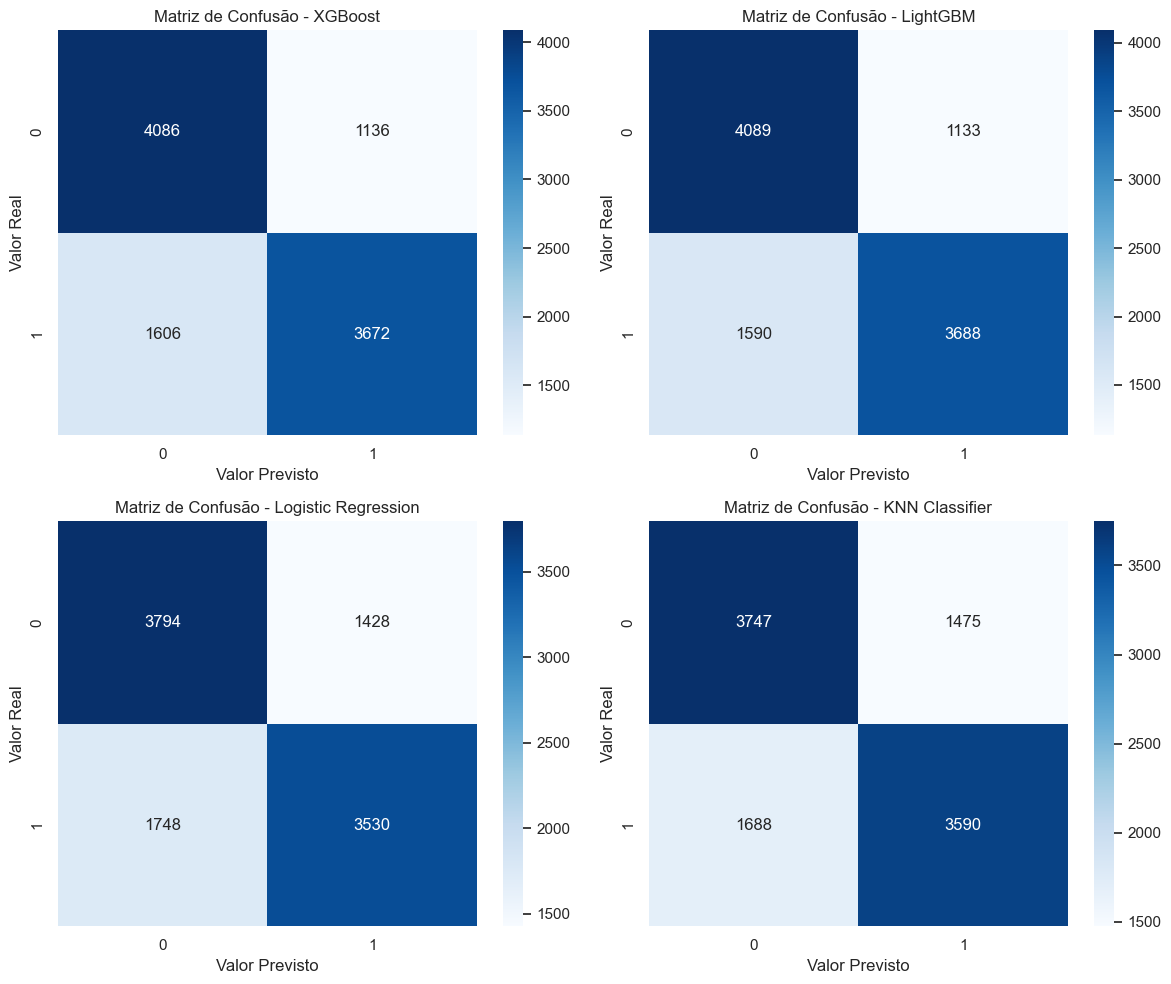

In [223]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Definindo os modelos
xgb_model = xgb.XGBClassifier()
lgbm_model = lgb.LGBMClassifier()
lr_model = LogisticRegression()
knn_model = KNeighborsClassifier()

models = [xgb_model, lgbm_model, lr_model, knn_model]
model_names = ['XGBoost', 'LightGBM', 'Logistic Regression', 'KNN Classifier']

# Treinando cada modelo
for model in models:
    model.fit(X_train, y_train)

# Configurações para o subplot
num_rows = 2
num_cols = 2
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 10))

# Iterando sobre os modelos e gerando as matrizes de confusão
for i, (model, model_name) in enumerate(zip(models, model_names)):
    row = i // num_cols
    col = i % num_cols
    
    # Realizando a predição do modelo
    y_pred = model.predict(X_test)
    
    # Gerando a matriz de confusão
    cm = confusion_matrix(y_test, y_pred)
    
    # Plotando a matriz de confusão
    ax = axes[row, col]
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', ax=ax)
    ax.set_title(f'Matriz de Confusão - {model_name}')
    ax.set_xlabel('Valor Previsto')
    ax.set_ylabel('Valor Real')

# Ajustando o layout
plt.tight_layout()
plt.show()


[LightGBM] [Info] Number of positive: 29701, number of negative: 29799
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001393 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 482
[LightGBM] [Info] Number of data points in the train set: 59500, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499176 -> initscore=-0.003294
[LightGBM] [Info] Start training from score -0.003294


C:\Users\Pichau\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


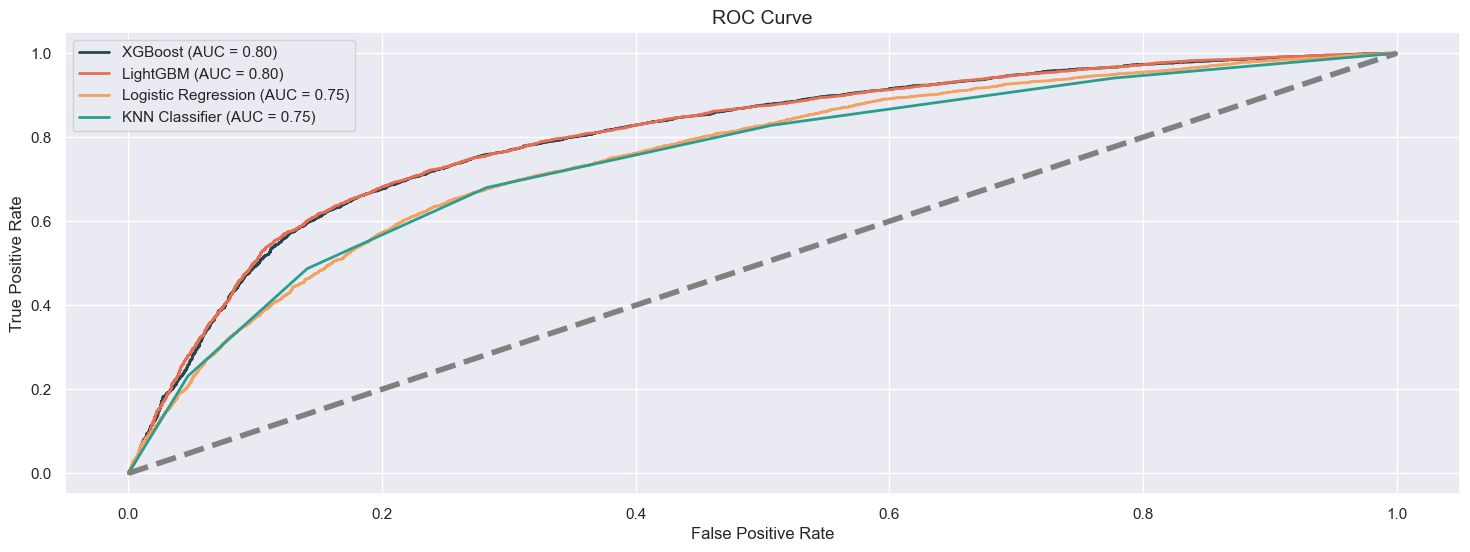

In [224]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
import lightgbm as lgb

# Treinar modelos
xgb_model = xgb.XGBClassifier()
xgb_model.fit(X_train, y_train)

lgbm_model = lgb.LGBMClassifier()
lgbm_model.fit(X_train, y_train)

lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)

knn_model = KNeighborsClassifier()
knn_model.fit(X_train, y_train)

# Calcular probabilidades previstas
xgb_y_proba = xgb_model.predict_proba(X_test)[:, 1]
lgbm_y_proba = lgbm_model.predict_proba(X_test)[:, 1]
lr_y_proba = lr_model.predict_proba(X_test)[:, 1]
knn_y_proba = knn_model.predict_proba(X_test)[:, 1]

# Calcular curvas ROC
xgb_fpr, xgb_tpr, _ = roc_curve(y_test, xgb_y_proba)
lgbm_fpr, lgbm_tpr, _ = roc_curve(y_test, lgbm_y_proba)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_y_proba)
knn_fpr, knn_tpr, _ = roc_curve(y_test, knn_y_proba)

# Calcular áreas sob a curva ROC (AUC)
xgb_auc = auc(xgb_fpr, xgb_tpr)
lgbm_auc = auc(lgbm_fpr, lgbm_tpr)
lr_auc = auc(lr_fpr, lr_tpr)
knn_auc = auc(knn_fpr, knn_tpr)



# Plotar as curvas ROC para cada modelo com a paleta de cores personalizada
plt.plot(xgb_fpr, xgb_tpr, label=f'XGBoost (AUC = {xgb_auc:.2f})', color=LAYOUT_PALETTE2[0], linewidth=2)
plt.plot(lgbm_fpr, lgbm_tpr, label=f'LightGBM (AUC = {lgbm_auc:.2f})', color=LAYOUT_PALETTE2[1], linewidth=2)
plt.plot(lr_fpr, lr_tpr, label=f'Logistic Regression (AUC = {lr_auc:.2f})', color=LAYOUT_PALETTE2[2], linewidth=2)
plt.plot(knn_fpr, knn_tpr, label=f'KNN Classifier (AUC = {knn_auc:.2f})', color=LAYOUT_PALETTE2[3], linewidth=2)

# Plotar a linha de referência diagonal
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', linewidth=4)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve', fontsize=14)
plt.legend()
plt.grid(True)
plt.show();


## Final Model

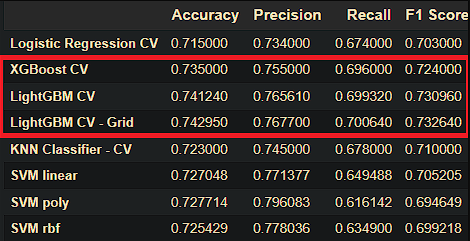

- Nota-se que tanto o XGBoost quanto o LightGBM apresentaram bons resultados, tanto nas métricas quanto na curva ROC que demonstra quão bem o modelo performa na distinção entre as classes positiva e negativa, ou seja, o quão bem ele consegue classificar de forma correta.


- Apesar do caso revelar que apenas a métrica de precisão é considerada para a precificação do serviço, deve-se levar em conta outras métricas, como a recall por exemplo, que no caso, mede a capacidade do teste em identificar corretamente os casos positivos da doença. Um modelo com recall baixo, acaba por não identificar um diagnóstico com mais frequência. Tal fato poderia comprometer a credibilidade da empresa e por isso deve ser considerado. Dessa maneira, o ideal é usar o F1 Score como referencial para a escolha do modelo, uma vez que representa o equilíbrio entre as duas métricas (precisão e recall).


- Com essa abordagem, foi possível filtrar quais modelos estariam aptos a serem utilizados, ficando entre o XGBoost e o LightGBM. É possível perceber também que o modelo de LightGBM performa quase igual o XGBoost, dado que ambos são implementações de gradient boosting, técnica de aprendizado que se utiliza da combinação de árvores de decisão fracas para melhoria do modelo. Optei por usar o LightGBM dado à sua velocidade de execução, que traz agilidade ao processo, gerando valor em um menor período de tempo.

In [171]:
best_params = g_lgbm.best_params_
print("Melhores parâmetros encontrados:")
print(best_params)


Melhores parâmetros encontrados:
{'colsample_bytree': 0.65, 'learning_rate': 0.005, 'n_estimators': 40, 'num_boost_round': 3000, 'num_leaves': 16, 'random_state': 501, 'reg_alpha': 0.05, 'reg_lambda': 0.05, 'subsample': 0.7}


In [177]:
final_params = { 
    'learning_rate': 0.005,
    'n_estimators': 40,
    'num_leaves': 16, 
    'random_state': 501,
    'num_boost_round': 3000,
    'colsample_bytree': 0.65,
    'subsample': 0.7,
    'reg_alpha': 0.05,
    'reg_lambda': 0.05, 
}

lgbm_model = lgb.LGBMClassifier(boosting_type='gbdt', **final_params, early_stopping_rounds=10)

final_model_lgbm = lgbm_model.fit(X_train, y_train)

[LightGBM] [Warning] num_iterations is set=3000, num_boost_round=3000 will be ignored. Current value: num_iterations=3000
[LightGBM] [Warning] early_stopping_round is set=10, early_stopping_rounds=10 will be ignored. Current value: early_stopping_round=10
[LightGBM] [Info] Number of positive: 29701, number of negative: 29799
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001352 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 482
[LightGBM] [Info] Number of data points in the train set: 59500, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499176 -> initscore=-0.003294
[LightGBM] [Info] Start training from score -0.003294


C:\Users\Pichau\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


ValueError: For early stopping, at least one dataset and eval metric is required for evaluation

In [198]:
# Fazendo previsões nos dados de teste
y_lgbm_final_pred = final_model_lgbm.predict(X_test)

# Avaliando o desempenho do modelo
accuracy = accuracy_score(y_test, y_lgbm_final_pred)
precision = precision_score(y_test, y_lgbm_final_pred)
recall = recall_score(y_test, y_lgbm_final_pred)
f1 = f1_score(y_test, y_lgbm_final_pred)

# Imprimindo métricas de desempenho
print("Accuracy:",accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


Accuracy: 0.7421904761904762
Precision: 0.7653250773993808
Recall: 0.7025388404698749
F1 Score: 0.73258915341302


In [215]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
import numpy as np

# Defina a função para calcular a média e o desvio padrão de todas as métricas usando validação cruzada
def metrics_with_cv(model, X_train, y_train):
    scorers = {'accuracy': accuracy_score, 'precision': precision_score, 'recall': recall_score, 'f1': f1_score}
    metrics_dict = {}
    for metric_name, scorer in scorers.items():
        cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring=make_scorer(scorer))  # 5-fold cross-validation
        mean_metric = np.mean(cv_scores)
        std_metric = np.std(cv_scores)
        mean_metric_formatted = '{:.4f}'.format(mean_metric)
        std_metric_formatted = '{:.4f}'.format(std_metric)
        metrics_dict[metric_name] = {'mean': mean_metric_formatted, 'std': std_metric_formatted}
    return metrics_dict

# Calcular média e desvio padrão de todas as métricas usando validação cruzada
metrics_results = metrics_with_cv(final_model_lgbm, X_train, y_train);

C:\Users\Pichau\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] num_iterations is set=3000, num_boost_round=3000 will be ignored. Current value: num_iterations=3000
[LightGBM] [Info] Number of positive: 23761, number of negative: 23839
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001070 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 478
[LightGBM] [Info] Number of data points in the train set: 47600, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499181 -> initscore=-0.003277
[LightGBM] [Info] Start training from score -0.003277


C:\Users\Pichau\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] num_iterations is set=3000, num_boost_round=3000 will be ignored. Current value: num_iterations=3000
[LightGBM] [Info] Number of positive: 23761, number of negative: 23839
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001145 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 471
[LightGBM] [Info] Number of data points in the train set: 47600, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499181 -> initscore=-0.003277
[LightGBM] [Info] Start training from score -0.003277


C:\Users\Pichau\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] num_iterations is set=3000, num_boost_round=3000 will be ignored. Current value: num_iterations=3000
[LightGBM] [Info] Number of positive: 23761, number of negative: 23839
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001101 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 47600, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499181 -> initscore=-0.003277
[LightGBM] [Info] Start training from score -0.003277


C:\Users\Pichau\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] num_iterations is set=3000, num_boost_round=3000 will be ignored. Current value: num_iterations=3000
[LightGBM] [Info] Number of positive: 23761, number of negative: 23839
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001187 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 474
[LightGBM] [Info] Number of data points in the train set: 47600, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499181 -> initscore=-0.003277
[LightGBM] [Info] Start training from score -0.003277


C:\Users\Pichau\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] num_iterations is set=3000, num_boost_round=3000 will be ignored. Current value: num_iterations=3000
[LightGBM] [Info] Number of positive: 23760, number of negative: 23840
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001116 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 478
[LightGBM] [Info] Number of data points in the train set: 47600, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499160 -> initscore=-0.003361
[LightGBM] [Info] Start training from score -0.003361


C:\Users\Pichau\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] num_iterations is set=3000, num_boost_round=3000 will be ignored. Current value: num_iterations=3000
[LightGBM] [Info] Number of positive: 23761, number of negative: 23839
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001146 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 478
[LightGBM] [Info] Number of data points in the train set: 47600, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499181 -> initscore=-0.003277
[LightGBM] [Info] Start training from score -0.003277


C:\Users\Pichau\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] num_iterations is set=3000, num_boost_round=3000 will be ignored. Current value: num_iterations=3000
[LightGBM] [Info] Number of positive: 23761, number of negative: 23839
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001071 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 471
[LightGBM] [Info] Number of data points in the train set: 47600, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499181 -> initscore=-0.003277
[LightGBM] [Info] Start training from score -0.003277


C:\Users\Pichau\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] num_iterations is set=3000, num_boost_round=3000 will be ignored. Current value: num_iterations=3000
[LightGBM] [Info] Number of positive: 23761, number of negative: 23839
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001277 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 47600, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499181 -> initscore=-0.003277
[LightGBM] [Info] Start training from score -0.003277


C:\Users\Pichau\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] num_iterations is set=3000, num_boost_round=3000 will be ignored. Current value: num_iterations=3000
[LightGBM] [Info] Number of positive: 23761, number of negative: 23839
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001139 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 474
[LightGBM] [Info] Number of data points in the train set: 47600, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499181 -> initscore=-0.003277
[LightGBM] [Info] Start training from score -0.003277


C:\Users\Pichau\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] num_iterations is set=3000, num_boost_round=3000 will be ignored. Current value: num_iterations=3000
[LightGBM] [Info] Number of positive: 23760, number of negative: 23840
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001121 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 478
[LightGBM] [Info] Number of data points in the train set: 47600, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499160 -> initscore=-0.003361
[LightGBM] [Info] Start training from score -0.003361


C:\Users\Pichau\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] num_iterations is set=3000, num_boost_round=3000 will be ignored. Current value: num_iterations=3000
[LightGBM] [Info] Number of positive: 23761, number of negative: 23839
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001190 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 478
[LightGBM] [Info] Number of data points in the train set: 47600, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499181 -> initscore=-0.003277
[LightGBM] [Info] Start training from score -0.003277


C:\Users\Pichau\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] num_iterations is set=3000, num_boost_round=3000 will be ignored. Current value: num_iterations=3000
[LightGBM] [Info] Number of positive: 23761, number of negative: 23839
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001151 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 471
[LightGBM] [Info] Number of data points in the train set: 47600, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499181 -> initscore=-0.003277
[LightGBM] [Info] Start training from score -0.003277


C:\Users\Pichau\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] num_iterations is set=3000, num_boost_round=3000 will be ignored. Current value: num_iterations=3000
[LightGBM] [Info] Number of positive: 23761, number of negative: 23839
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001116 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 47600, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499181 -> initscore=-0.003277
[LightGBM] [Info] Start training from score -0.003277


C:\Users\Pichau\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] num_iterations is set=3000, num_boost_round=3000 will be ignored. Current value: num_iterations=3000
[LightGBM] [Info] Number of positive: 23761, number of negative: 23839
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001201 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 474
[LightGBM] [Info] Number of data points in the train set: 47600, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499181 -> initscore=-0.003277
[LightGBM] [Info] Start training from score -0.003277


C:\Users\Pichau\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] num_iterations is set=3000, num_boost_round=3000 will be ignored. Current value: num_iterations=3000
[LightGBM] [Info] Number of positive: 23760, number of negative: 23840
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001451 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 478
[LightGBM] [Info] Number of data points in the train set: 47600, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499160 -> initscore=-0.003361
[LightGBM] [Info] Start training from score -0.003361


C:\Users\Pichau\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] num_iterations is set=3000, num_boost_round=3000 will be ignored. Current value: num_iterations=3000
[LightGBM] [Info] Number of positive: 23761, number of negative: 23839
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001149 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 478
[LightGBM] [Info] Number of data points in the train set: 47600, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499181 -> initscore=-0.003277
[LightGBM] [Info] Start training from score -0.003277


C:\Users\Pichau\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] num_iterations is set=3000, num_boost_round=3000 will be ignored. Current value: num_iterations=3000
[LightGBM] [Info] Number of positive: 23761, number of negative: 23839
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001122 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 471
[LightGBM] [Info] Number of data points in the train set: 47600, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499181 -> initscore=-0.003277
[LightGBM] [Info] Start training from score -0.003277


C:\Users\Pichau\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] num_iterations is set=3000, num_boost_round=3000 will be ignored. Current value: num_iterations=3000
[LightGBM] [Info] Number of positive: 23761, number of negative: 23839
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001387 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 47600, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499181 -> initscore=-0.003277
[LightGBM] [Info] Start training from score -0.003277


C:\Users\Pichau\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] num_iterations is set=3000, num_boost_round=3000 will be ignored. Current value: num_iterations=3000
[LightGBM] [Info] Number of positive: 23761, number of negative: 23839
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001330 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 474
[LightGBM] [Info] Number of data points in the train set: 47600, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499181 -> initscore=-0.003277
[LightGBM] [Info] Start training from score -0.003277


C:\Users\Pichau\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] num_iterations is set=3000, num_boost_round=3000 will be ignored. Current value: num_iterations=3000
[LightGBM] [Info] Number of positive: 23760, number of negative: 23840
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001118 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 478
[LightGBM] [Info] Number of data points in the train set: 47600, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499160 -> initscore=-0.003361
[LightGBM] [Info] Start training from score -0.003361


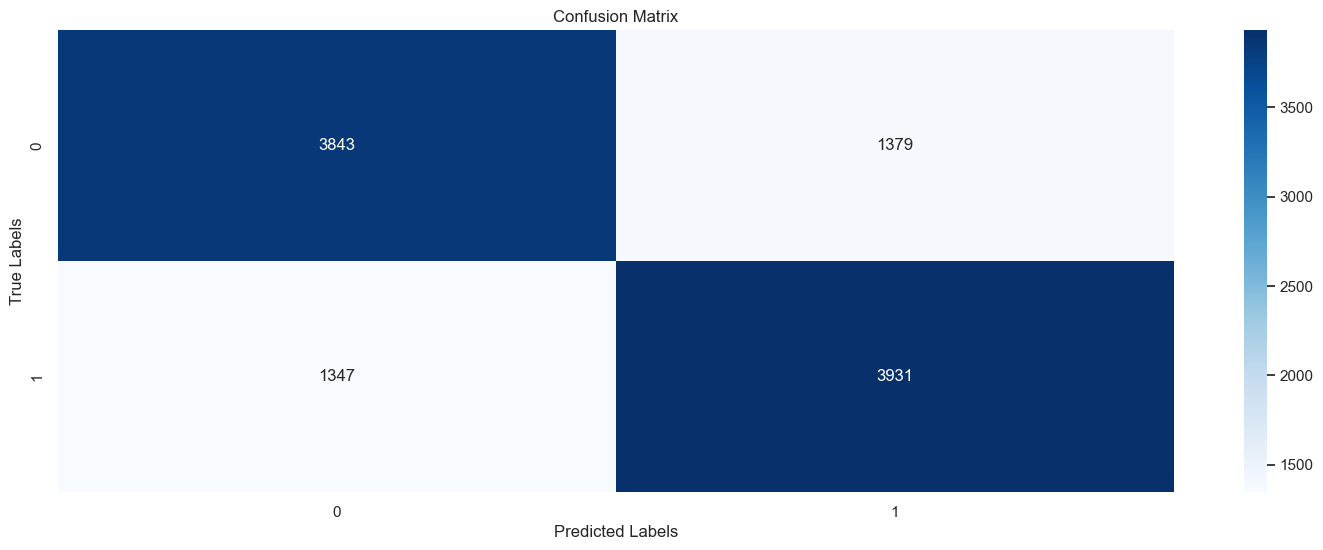

In [225]:
threshold = 0.45
# Predict the probabilities
final_model_lgbm_probs = final_model_lgbm.predict_proba(X_test)

# Keep probabilities for the positive outcome only
final_probs = final_model_lgbm_probs[:, 1]

# Apply the threshold
final_y_pred = np.where(final_probs > threshold, 1, 0)

# Calculate the confusion matrix
cm = confusion_matrix(y_test, final_y_pred)

# Create a heatmap of the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

In [226]:
metrics_results

{'accuracy': {'mean': '0.7368', 'std': '0.0028'},
 'precision': {'mean': '0.7560', 'std': '0.0035'},
 'recall': {'mean': '0.6981', 'std': '0.0076'},
 'f1': {'mean': '0.7259', 'std': '0.0039'}}

## Business Results and Conclusion

Para solucionarmos o problema e responder às questões do CEO da Cardio Catch Diseases, é necessário demonstrar o valor e ganho obtido com a aplicação do modelo proposto.

Lembrando que o a precificação do serviço da empresa acontece da seguinte forma:

    - Para os casos de precisão = 55% o valor pago pelo consumidor é de R$ 500 mas o custo se mantém fixo em R$ 1000, dessa forma tem uma margem negativa de R$ 500 por diagnóstico.

    - Para os casos de precisão = 60% o valor pago pelo consumidor é de R$ 1000 mas o custo se mantém fixo em R$ 1000, dessa forma se tem um breakeven, sem lucro ou prejuízo por diagnóstico.

    - Para os casos de precisão = 65% o valor pago pelo consumidor é de R$ 1500 mas o custo se mantém fixo em R$ 1000, dessa forma tem uma margem positiva de R$ 500 por diagnóstico e assim por diante a cada 5% a mais de precisão.
    
      
 Com o modelo proposto, foi possível atingir de uma forma estável uma precisão de **75\%** , resultando no seguinte cenário.<br>
<br>

   | Precisão     | Valor Cobrado     | Custo Fixo     | Lucro/diagnóstico|
   |:-------------|:------------------|:---------------|:-----------------|
   |     75%      |    R\$2500\.00    |   R\$1000\.00  |   R\$1500\.00    |
    
 <br>
    
**Como não há uma estimativa de diagnósticos mensais, peguei como base o número de pacientes da base de dados e dividi pelo número de anos que, por lei, as instituições de saúde devem armazenar cópias de exames, que seriam 20 anos. Dessa forma assumi que houveram 3500 diagnósticos ao ano, ou seja, cerca de 292 diagnósticos/mês.**<br><br>
    
       
Com essas premissas, partimos de um modelo que era incerto e que poderia trazer um prejuízo à operação e trouxemos um modelo rentável e estável, trazendo um lucro médio mensal de R\$ 438.000<br>
<br>
    
    
| Precisão     | Valor Cobrado     | Custo Fixo     | Lucro/diagnóstico|  Número de diagnósticos/mês   |   Lucro mensal   |
|:-------------|:------------------|:---------------|:-----------------|:------------------------------|:-----------------|
|     75%      |    R\$2\.500\,00    |   R\$1\.000\,00  |   R\$1\.500\,00    |           292 (premissa)      |    R\$438\.000\,00
    
    

## Recomendations

1. Dado que parte da dificuldade do caso foi interpretar alguns valores e entender que houveram casos de typos, se faz necessário a checagem da cadeia de dados, garantindo que os valores sejam corretamente preenchidos


2. Adicionar coletas de outras variáveis relacionadas à saúde, como por exemplo se há histórico na família, para melhorar ainda mais a precisão do modelo futuramente

## Next Steps

1. Colocar o modelo em produção usando nuvem (AWS / Google Cloud)